# Preprocessing of the dataset

### Ho usato gli stessi valori che nel preprocessing del dataset d'esempio ma non ho capito in base a cosa si scelgono

In [60]:
import numpy as np
import pandas as pd
import scanpy as sc
import SCCAF 
import matplotlib.pyplot as plt

In [61]:
sc.settings.verbosity = 3             
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.12.2 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [62]:
results_file = './write/MouseData.h5ad'

In [63]:
adata=sc.read_10x_mtx('./filtered_feature_bc_matrix/',
    var_names='gene_symbols',
    cache=True)

... reading from cache file cache/filtered_feature_bc_matrix-matrix.h5ad


In [64]:
adata.shape
raw_data = adata

## Highest Gene Expressed
Per ogni gene calcola il numero di reads mappati e prende i primi 20: normalizza per ogni cellula i counts

normalizing counts per cell
    finished (0:00:00)


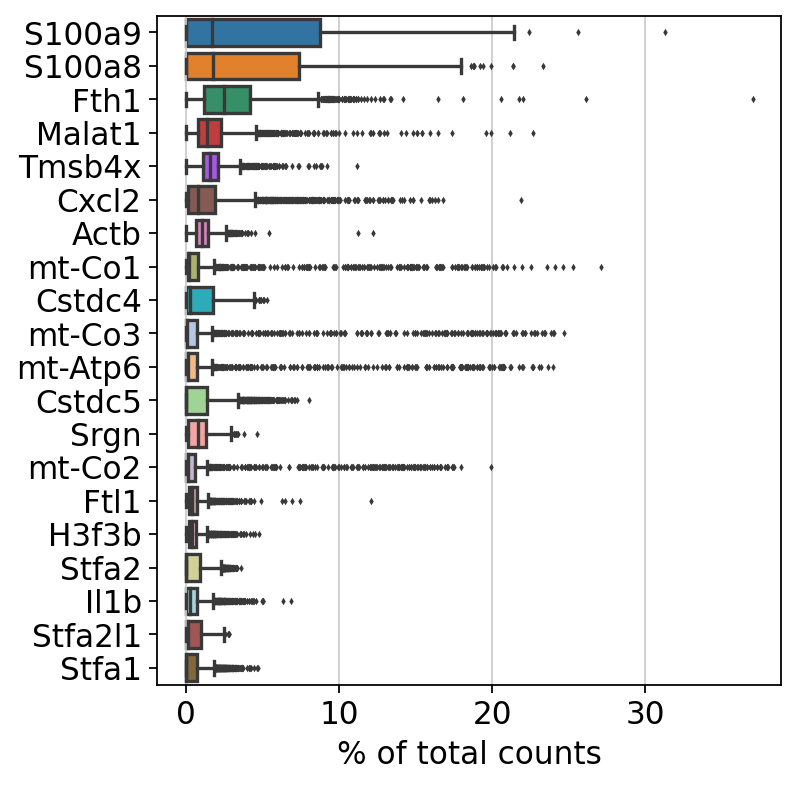

In [65]:
sc.pl.highest_expr_genes(adata, n_top=20) #i 20 geni più espressi

In [66]:
sc.pp.filter_cells(adata, min_genes=200) #filtro le cellule che hanno meno di 200 geni espressi
sc.pp.filter_genes(adata, min_cells=3) #filtro i geni espressi in meno di 3 cellule


filtered out 115 cells that have less than 200 genes expressed
filtered out 14742 genes that are detected in less than 3 cells


In [67]:
adata.var['mt']= adata.var_names.str.startswith('mt-') #annotazione dei gruppi di geni mitocondriali
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) #calcolo la percentuale di geni mitocondriali

In [68]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.pct_counts_mt < 12, :]
adata

View of AnnData object with n_obs × n_vars = 4362 × 17543
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [69]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [70]:
sc.pp.log1p(adata)

In [71]:
adata.raw = adata

In [72]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, flavor='cell_ranger') 

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [73]:
adata.raw=adata

In [74]:
adata = adata[:, adata.var.highly_variable]

In [75]:
sc.pp.regress_out(adata,  ['total_counts','pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:27)


In [76]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


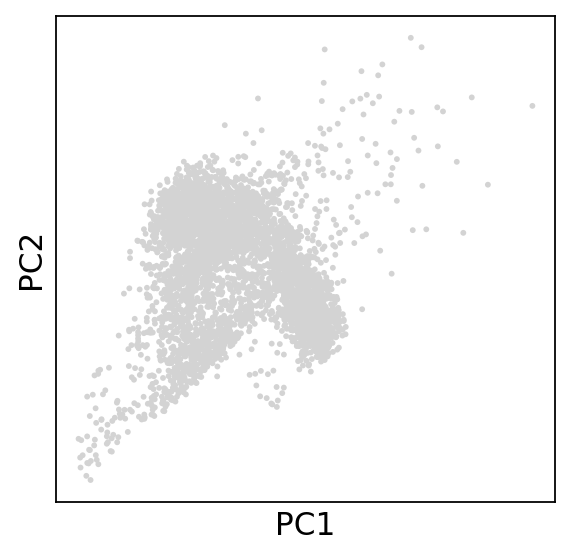

In [77]:
sc.pl.pca(adata)

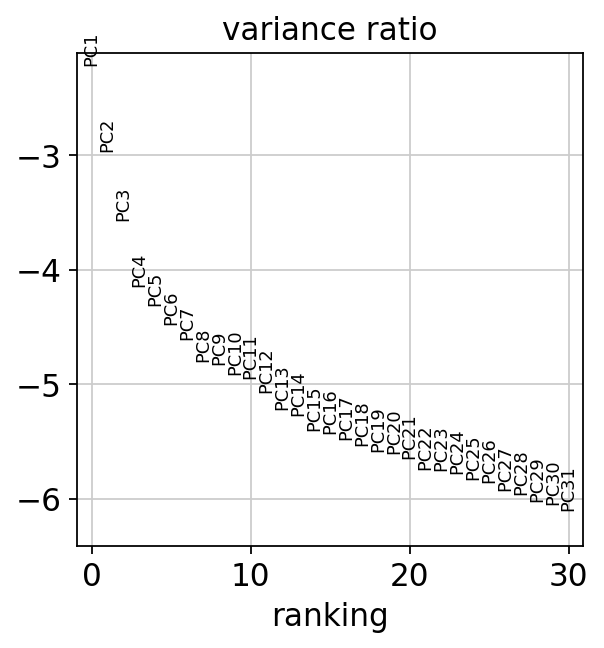

In [78]:
sc.pl.pca_variance_ratio(adata, log=True)

In [79]:
adata.write(results_file) 

In [80]:
adata

AnnData object with n_obs × n_vars = 4362 × 3311
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [81]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15) #provo con 15

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [82]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


In [83]:
sc.tl.louvain(adata, resolution=0.4)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


In [84]:
sc.tl.leiden(adata, resolution=0.4)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


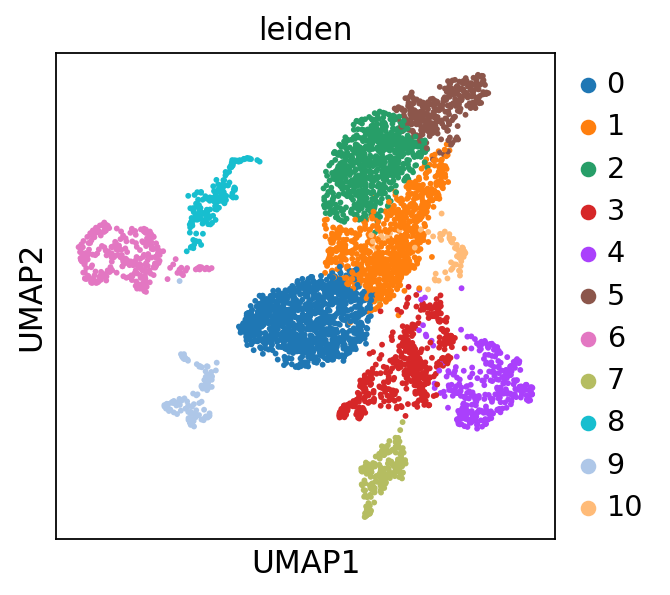

In [85]:
sc.pl.umap(adata, color=['leiden'])

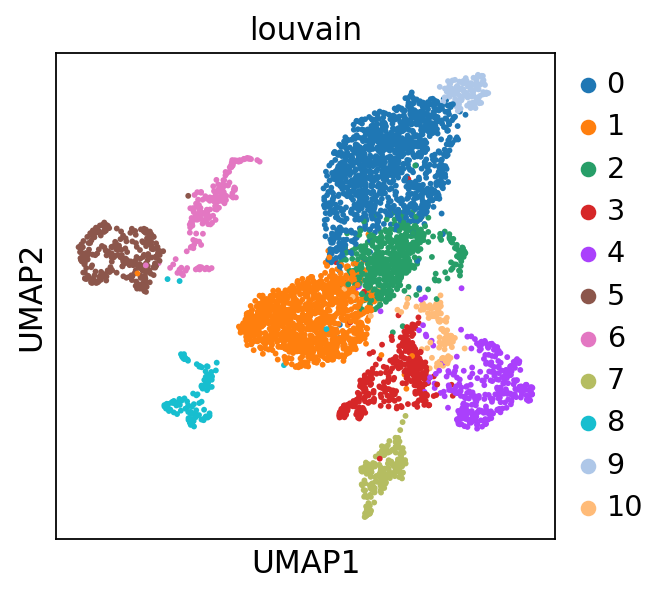

In [86]:
sc.pl.umap(adata, color=['louvain'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


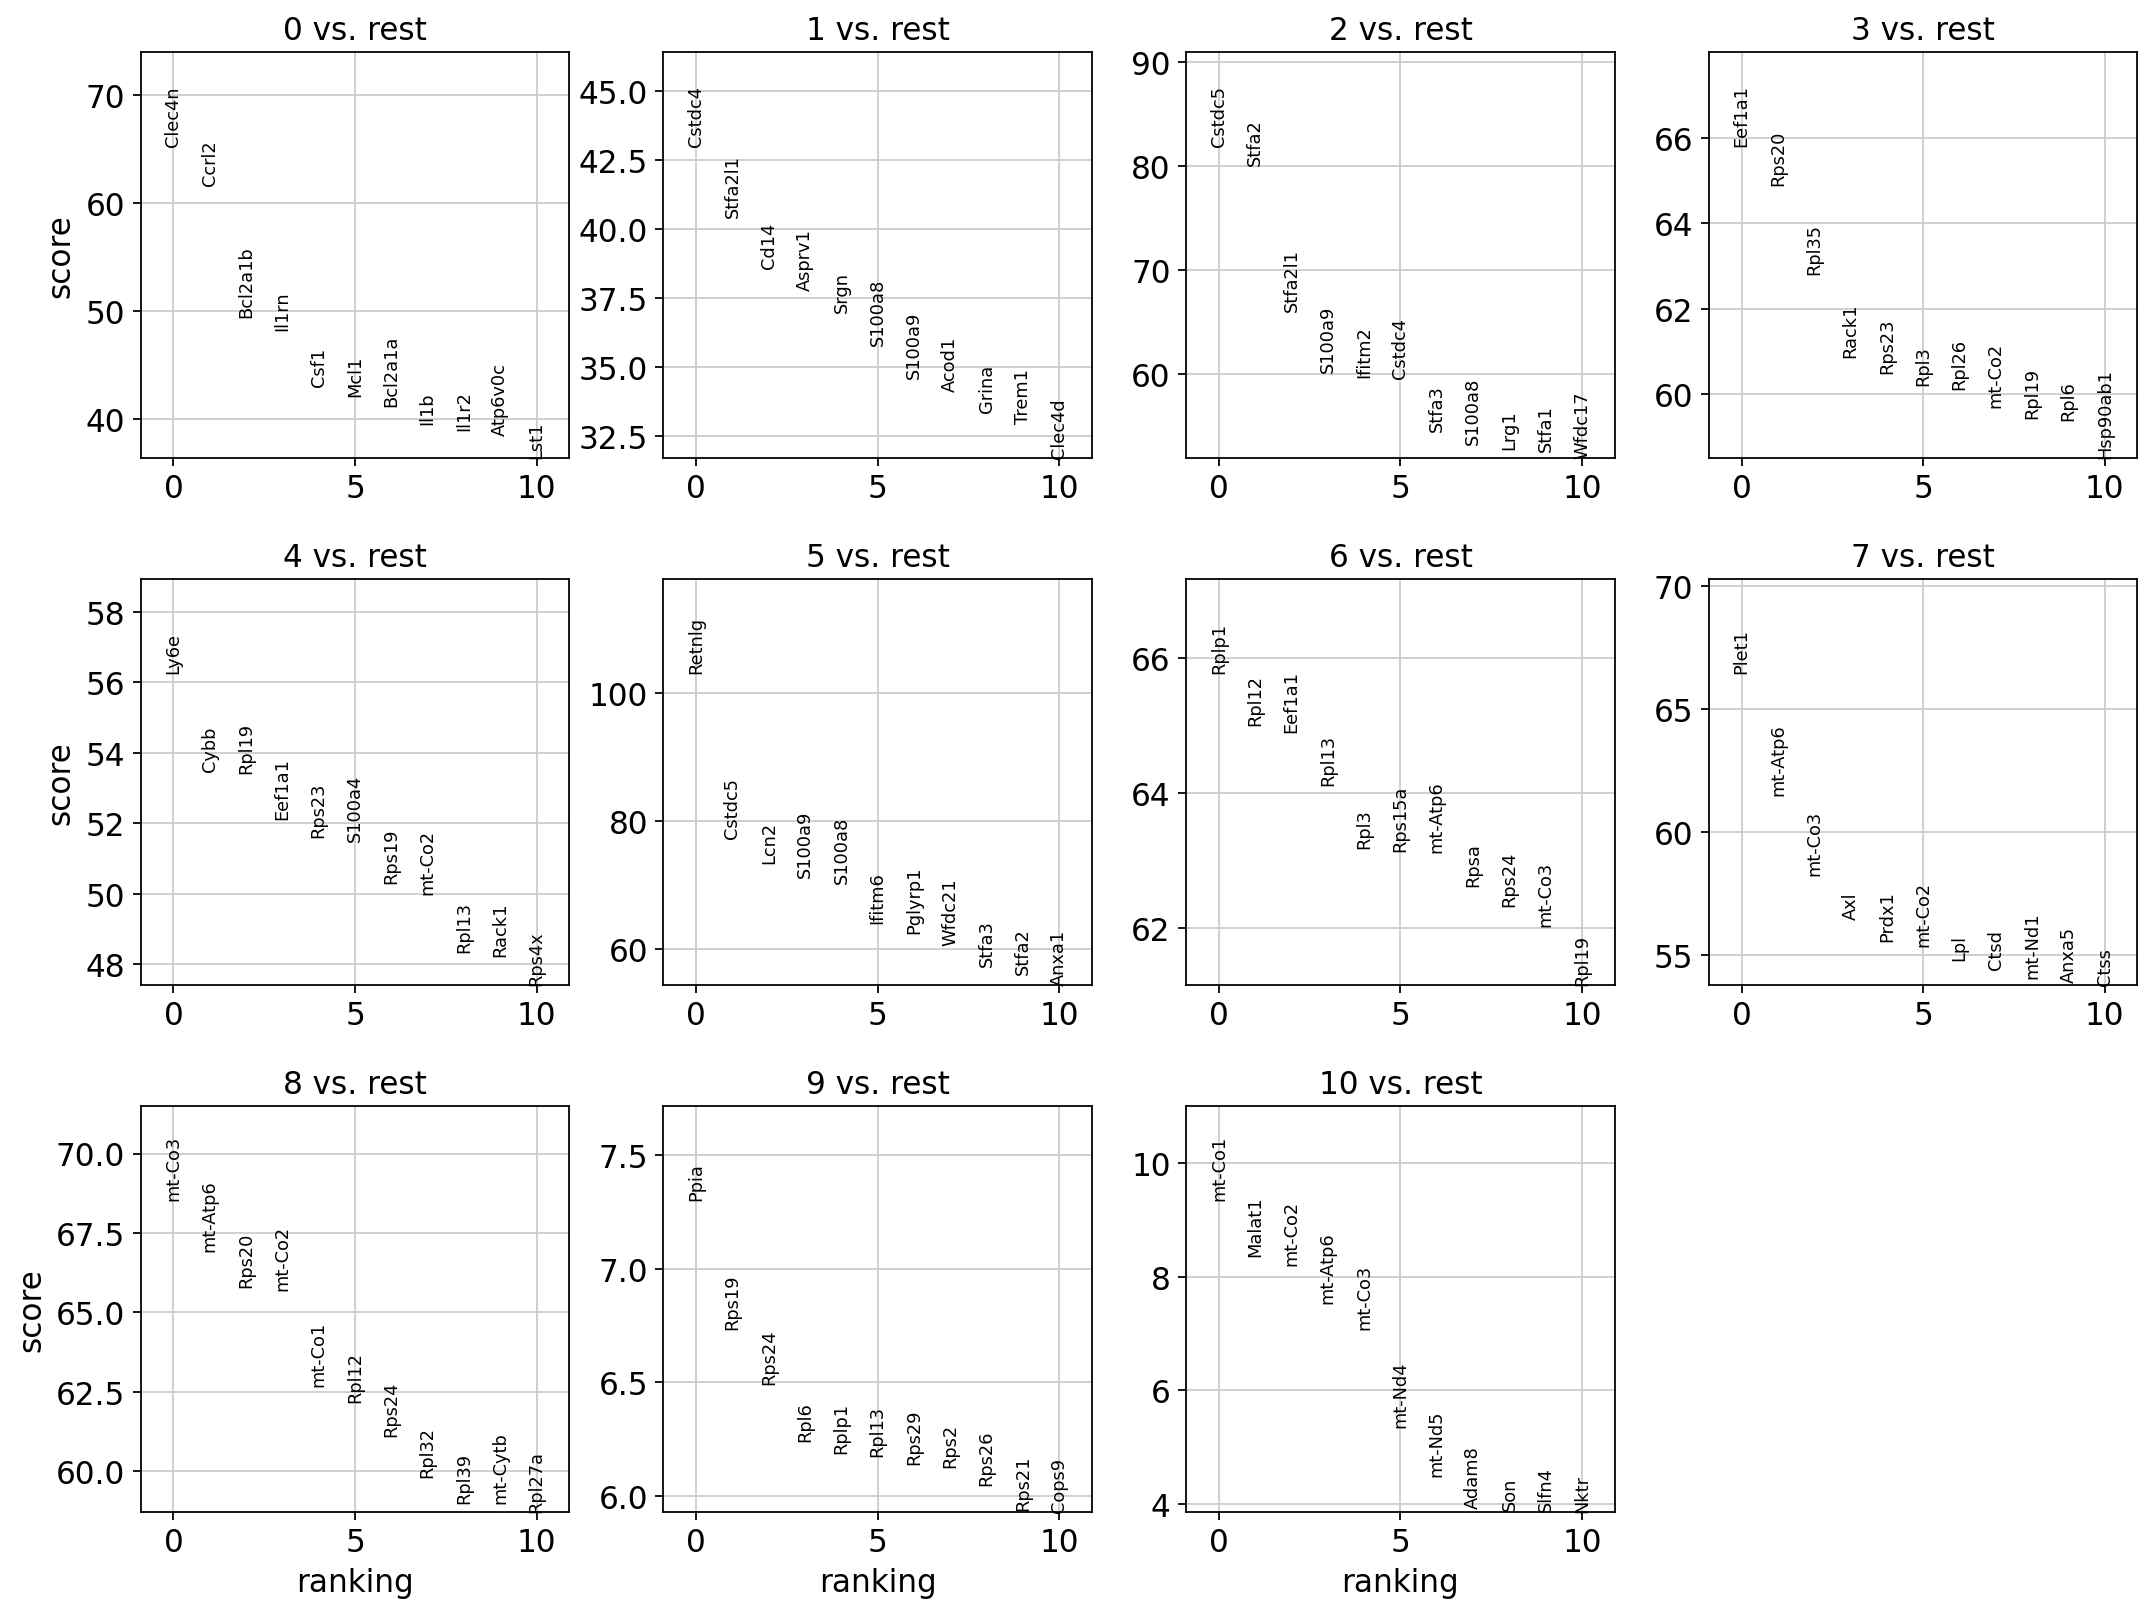

In [87]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=11, sharey=False)

In [88]:
sc.settings.verbosity=2

In [89]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")

from io import StringIO  # got moved to io in python3.
from glob import iglob
from SCCAF import *

Populating the interactive namespace from numpy and matplotlib


In [90]:
sc.tl.louvain(adata, resolution=1.5, key_added='louvain_r1.5')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')
sc.tl.louvain(adata, resolution=0.2, key_added='louvain_r0.2')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [91]:
adata

AnnData object with n_obs × n_vars = 4362 × 3311
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'louvain', 'leiden', 'louvain_r1.5', 'louvain_r0.5', 'louvain_r0.2'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'louvain', 'leiden', 'leiden_colors', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [92]:
adata.obs['L1_Round0'] = adata.obs['louvain_r1.5']

R1norm_cutoff: 0.500000
R2norm_cutoff: 0.050000
Accuracy: 0.000000
Round1 ...
Mean CV accuracy: 0.8248
Accuracy on the training set: 0.9044
Accuracy on the hold-out set: 0.8189


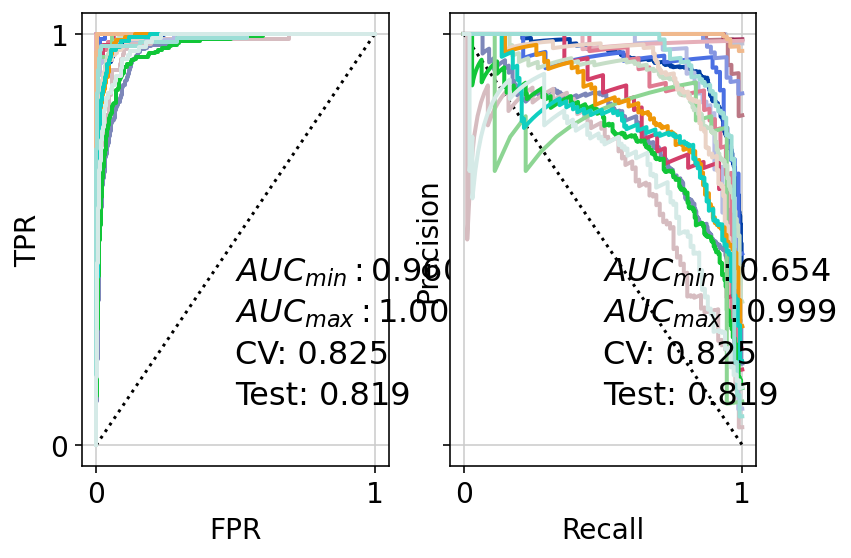

... storing 'L1_Round0_self-projection' as categorical


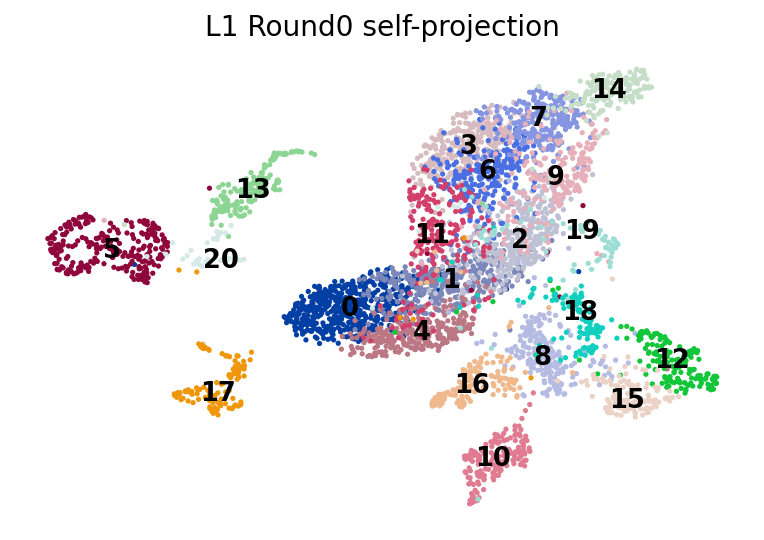

Accuracy on the training set: 0.9192
Accuracy on the hold-out set: 0.8065
Accuracy on the training set: 0.9150
Accuracy on the hold-out set: 0.8095
Max R1mat: 0.380282
Max R2mat: 0.021604
min_acc: 0.806524


<Figure size 432x288 with 0 Axes>

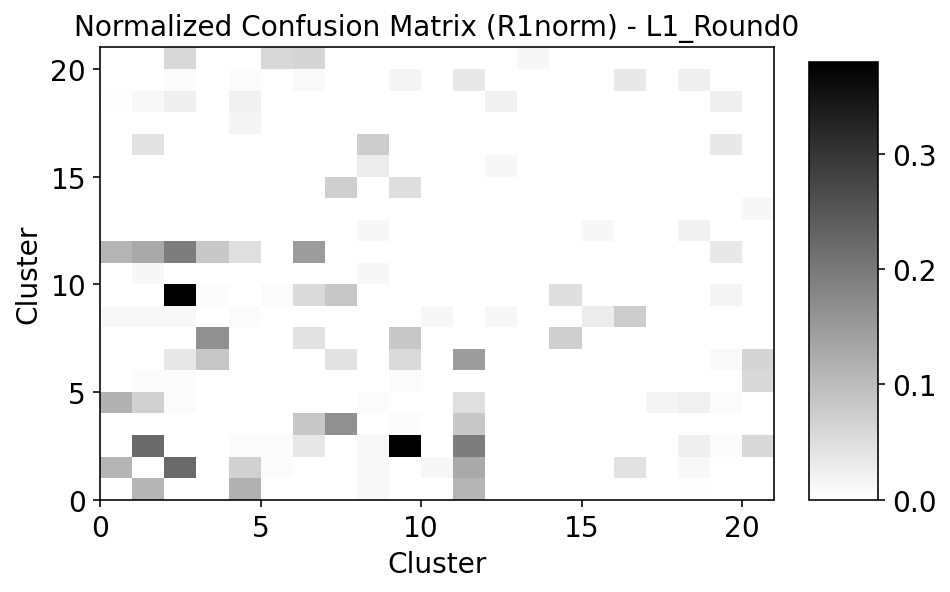

<Figure size 432x288 with 0 Axes>

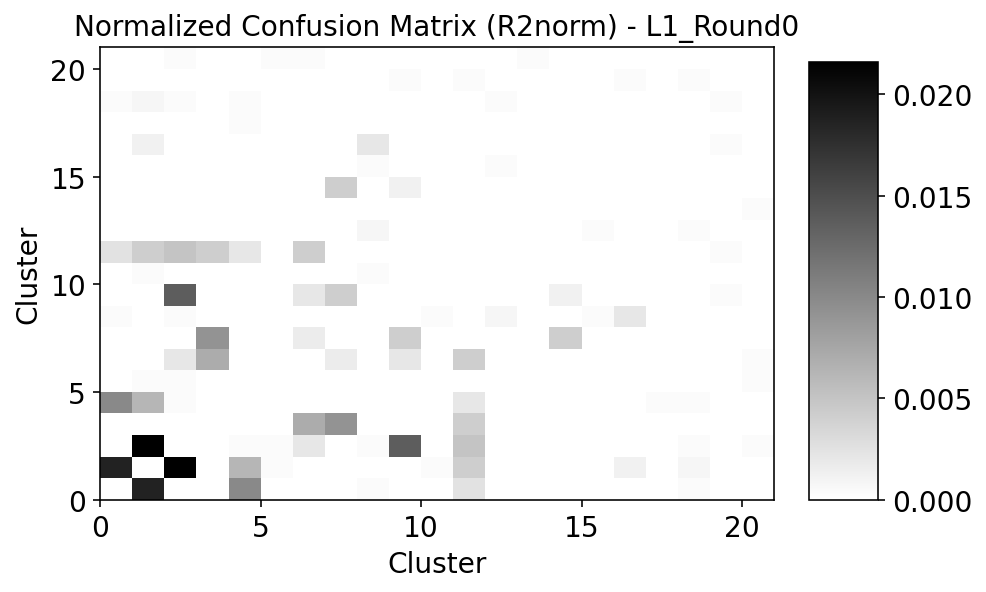

IGRAPH U-W- 21 0 --
+ attr: weight (e)
Converge SCCAF_optimize no. cluster!
m1: 0.380282
m2: 0.021604
Accuracy: 0.806524
R1norm_cutoff: 0.370282
R2norm_cutoff: 0.020604
Accuracy: 0.806524
Round1 ...
Mean CV accuracy: 0.8236
Accuracy on the training set: 0.9139
Accuracy on the hold-out set: 0.8196


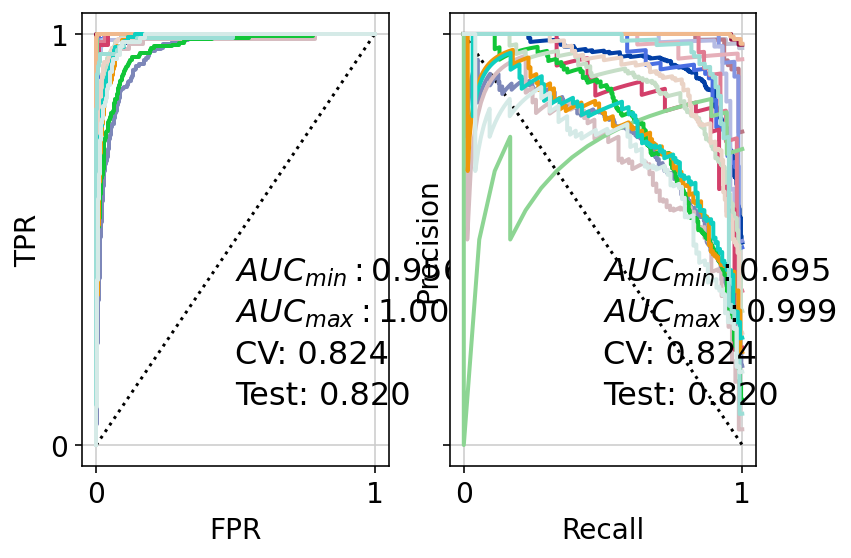

... storing 'L1_Round0_self-projection' as categorical


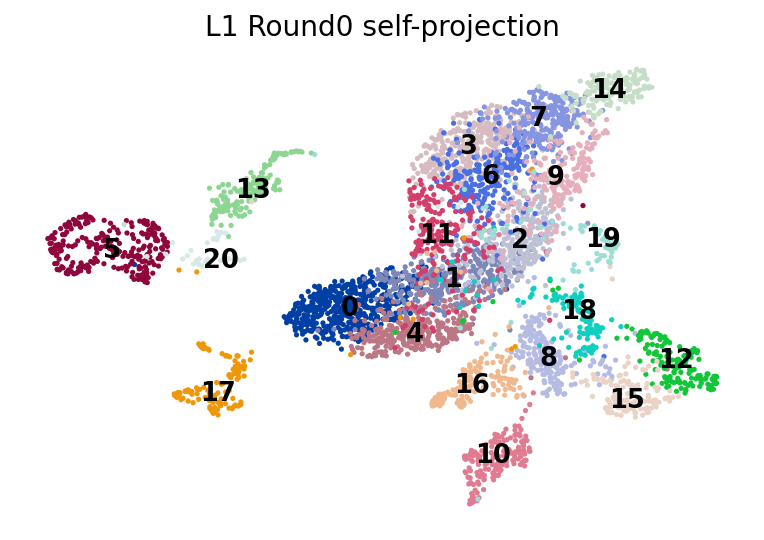

Accuracy on the training set: 0.9198
Accuracy on the hold-out set: 0.8069
Accuracy on the training set: 0.9162
Accuracy on the hold-out set: 0.8076
Max R1mat: 0.328571
Max R2mat: 0.022340
min_acc: 0.806899


<Figure size 432x288 with 0 Axes>

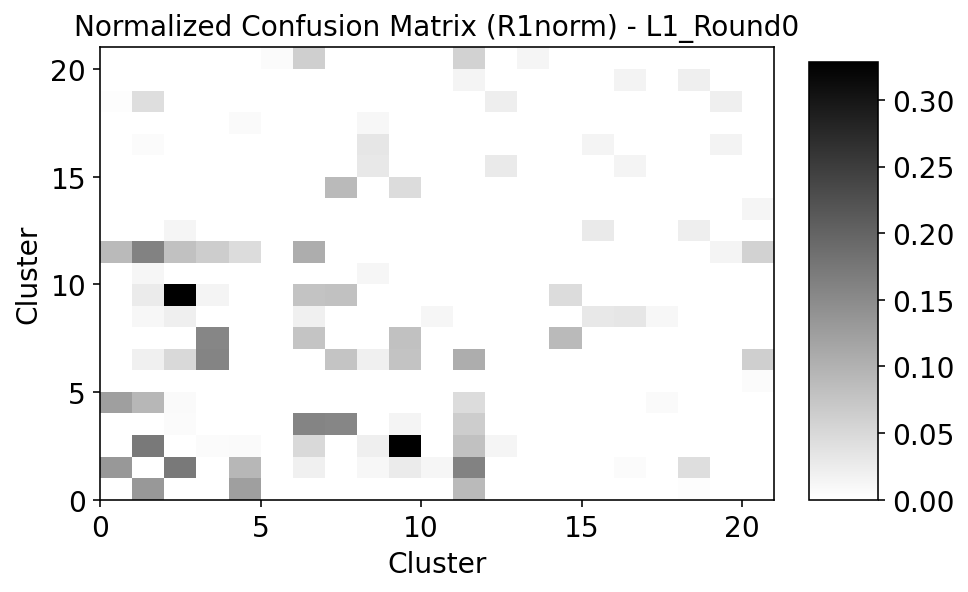

<Figure size 432x288 with 0 Axes>

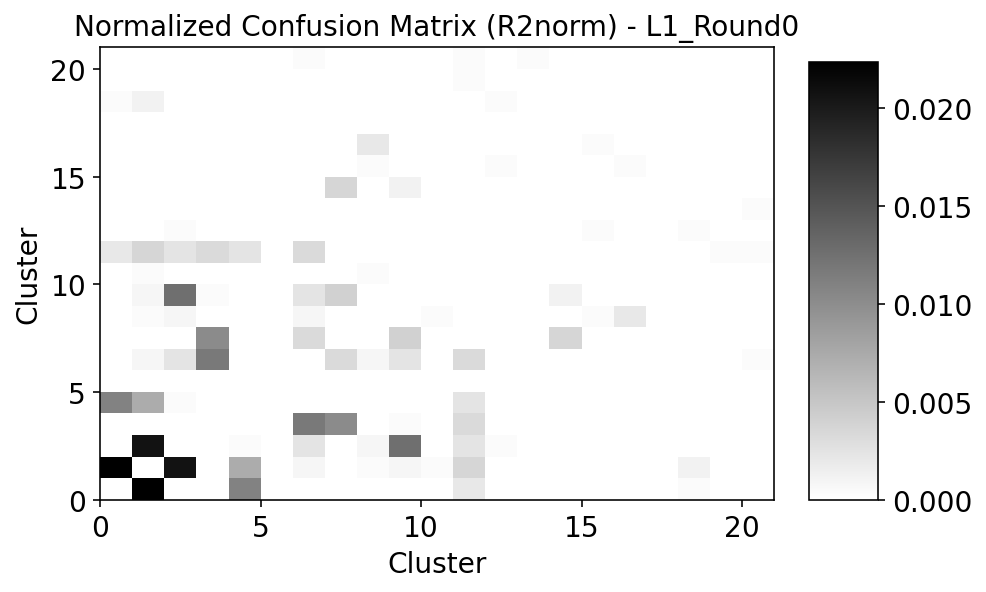

IGRAPH U-W- 21 0 --
+ attr: weight (e)
Converge SCCAF_optimize no. cluster!
m1: 0.328571
m2: 0.022340
Accuracy: 0.806899
R1norm_cutoff: 0.318571
R2norm_cutoff: 0.021340
Accuracy: 0.806899
Round1 ...
Mean CV accuracy: 0.8460
Accuracy on the training set: 0.9209
Accuracy on the hold-out set: 0.8181


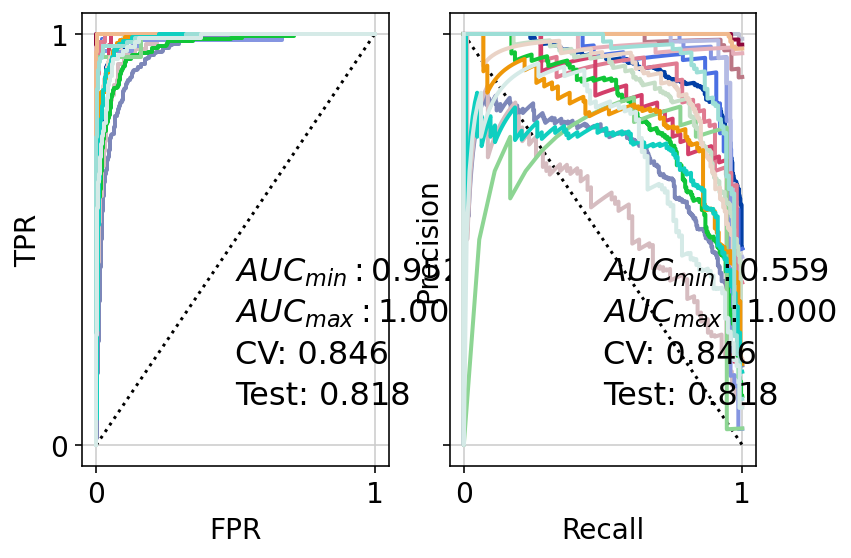

... storing 'L1_Round0_self-projection' as categorical


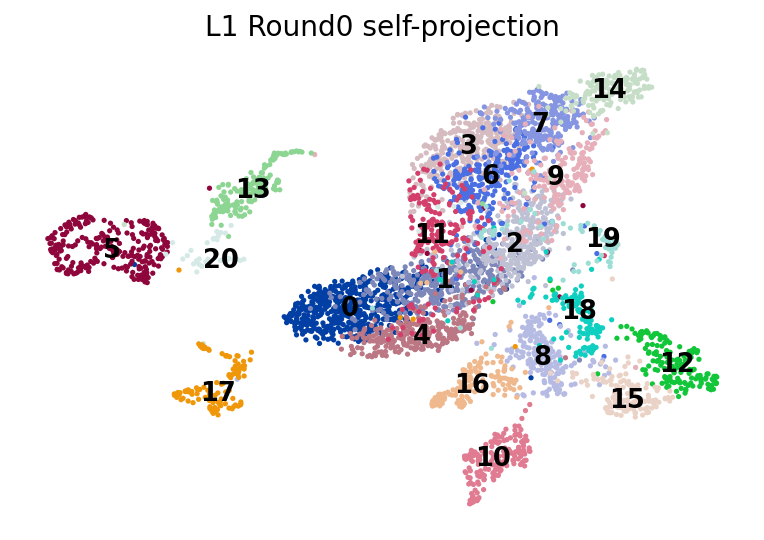

Accuracy on the training set: 0.9139
Accuracy on the hold-out set: 0.8155
Accuracy on the training set: 0.9121
Accuracy on the hold-out set: 0.8028
Max R1mat: 0.261538
Max R2mat: 0.028140
min_acc: 0.802775


<Figure size 432x288 with 0 Axes>

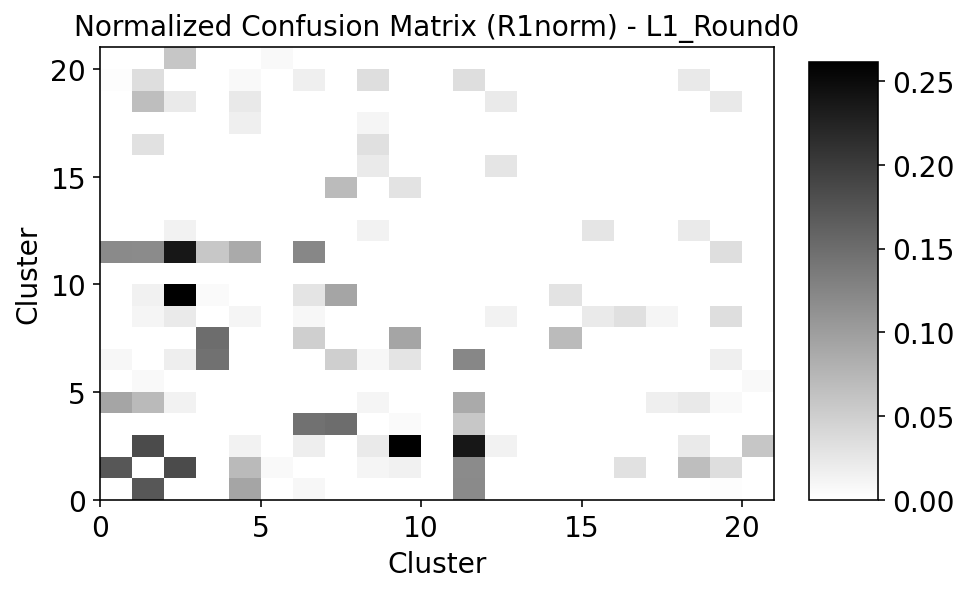

<Figure size 432x288 with 0 Axes>

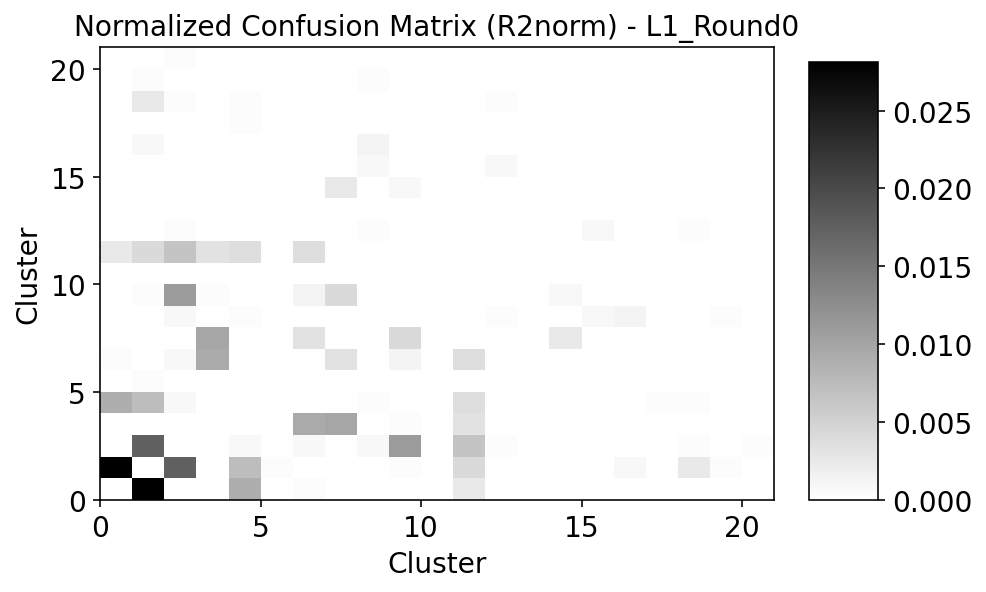

IGRAPH U-W- 21 0 --
+ attr: weight (e)
Converge SCCAF_optimize no. cluster!
m1: 0.261538
m2: 0.028140
Accuracy: 0.802775
R1norm_cutoff: 0.251538
R2norm_cutoff: 0.027140
Accuracy: 0.802775
Round1 ...
Mean CV accuracy: 0.8378
Accuracy on the training set: 0.9103
Accuracy on the hold-out set: 0.8031


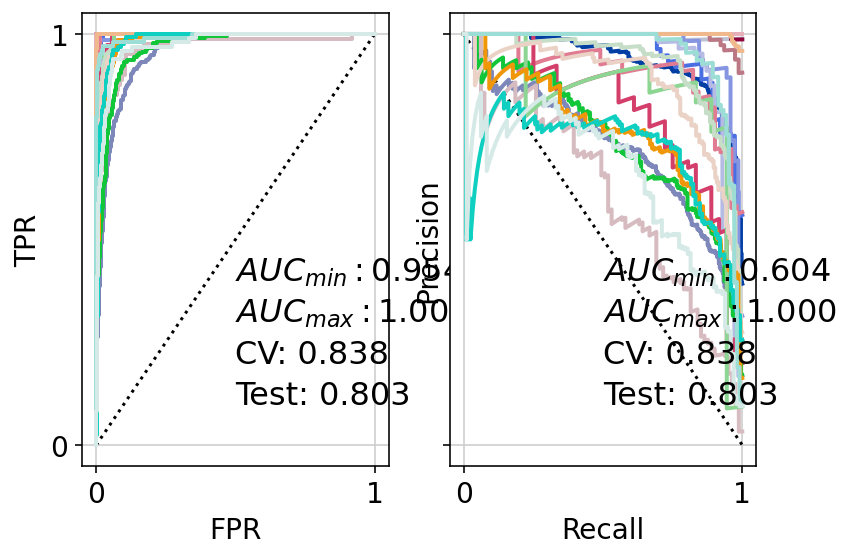

... storing 'L1_Round0_self-projection' as categorical


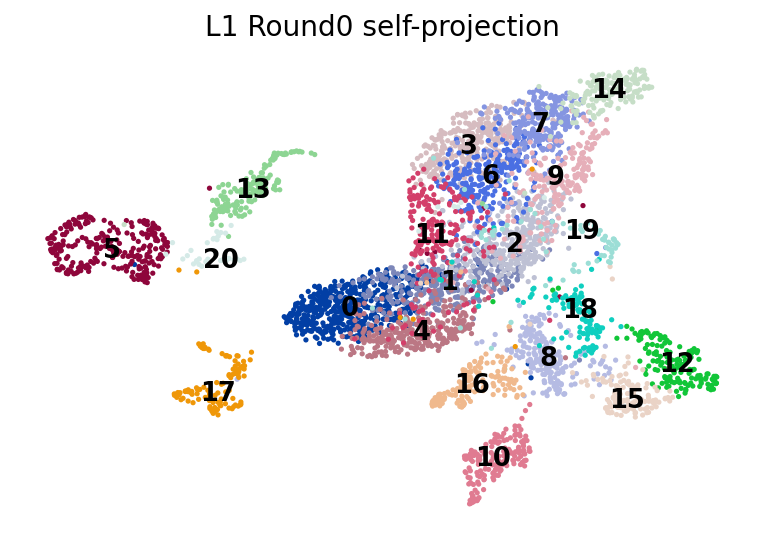

Accuracy on the training set: 0.9109
Accuracy on the hold-out set: 0.8129
Accuracy on the training set: 0.9180
Accuracy on the hold-out set: 0.8148
Max R1mat: 0.400000
Max R2mat: 0.022323
min_acc: 0.803150


<Figure size 432x288 with 0 Axes>

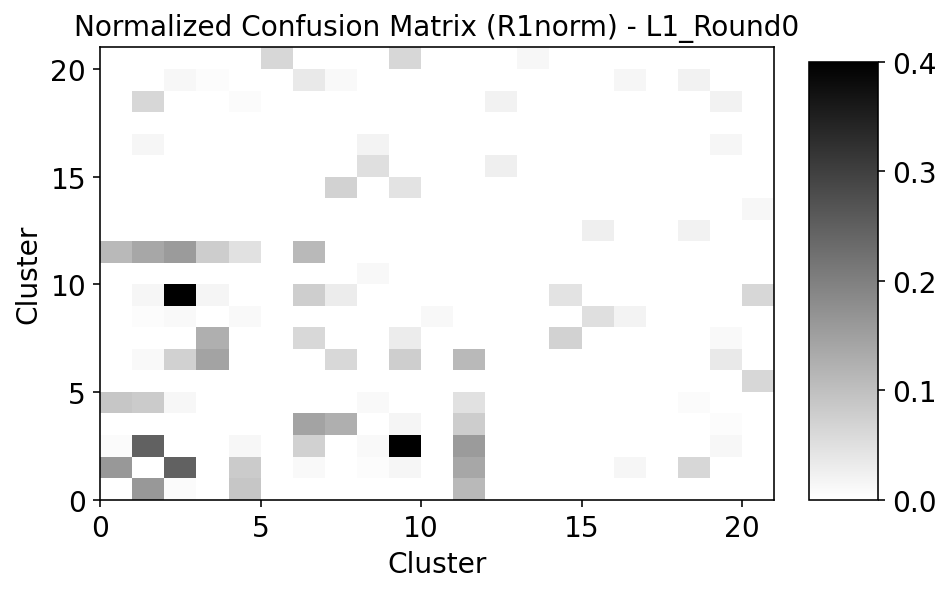

<Figure size 432x288 with 0 Axes>

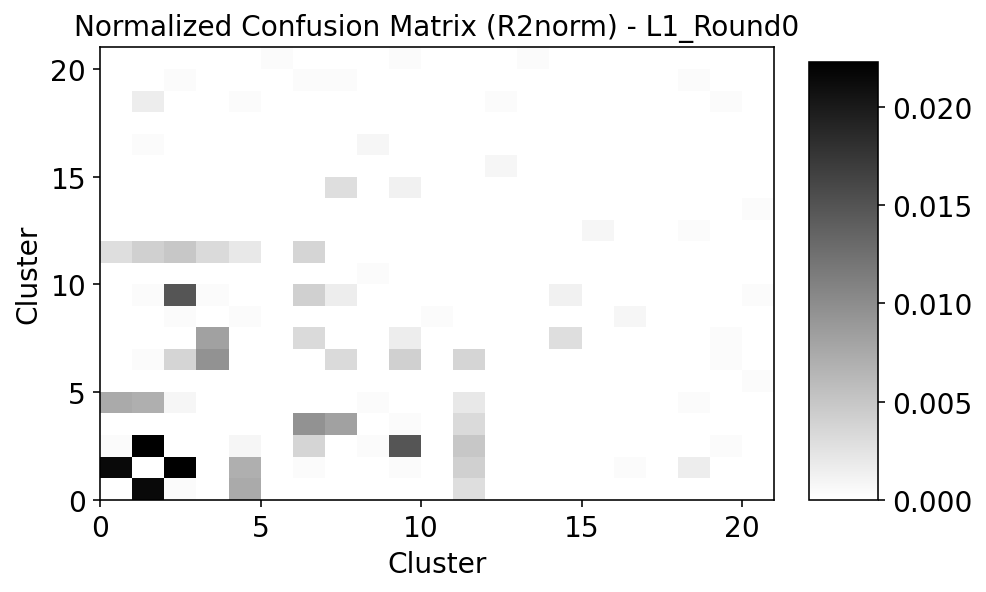

... storing 'L1_Round1' as categorical


IGRAPH U-W- 21 2 --
+ attr: weight (e)
+ edges:
2--9 2--9


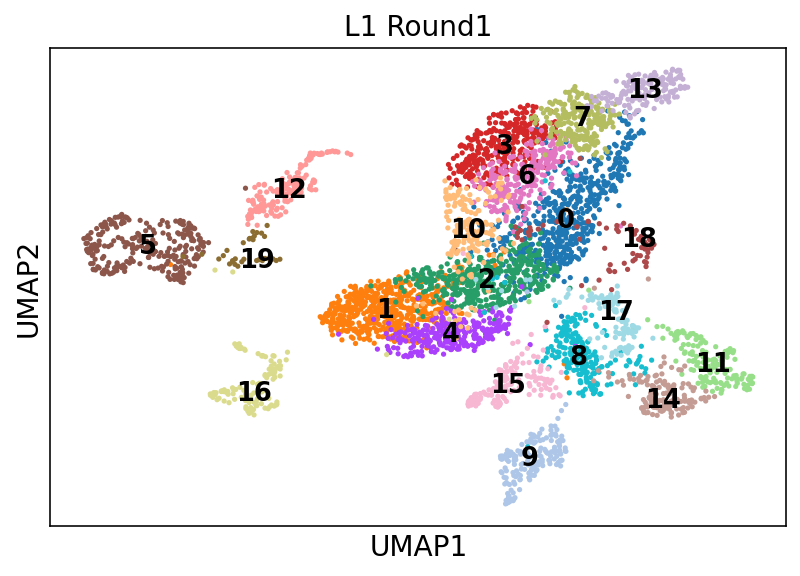

Round2 ...
Mean CV accuracy: 0.8542
Accuracy on the training set: 0.9237
Accuracy on the hold-out set: 0.8119


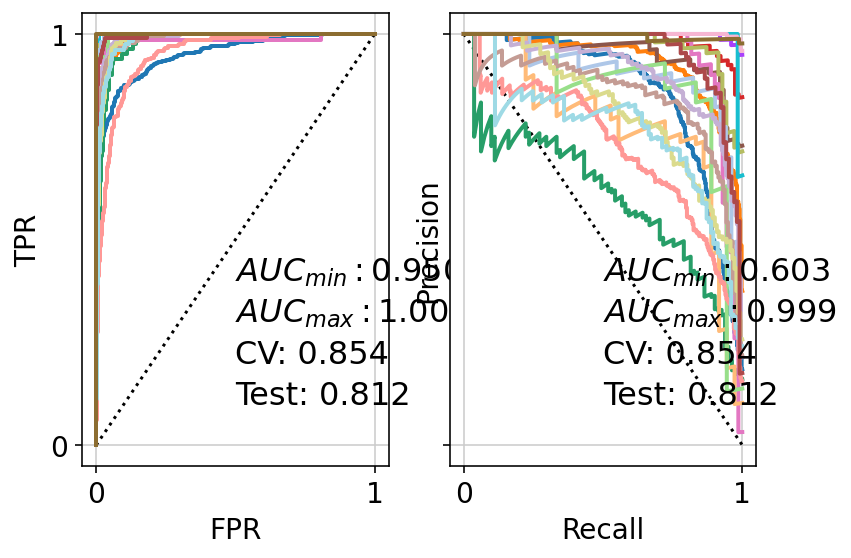

... storing 'L1_Round1_self-projection' as categorical


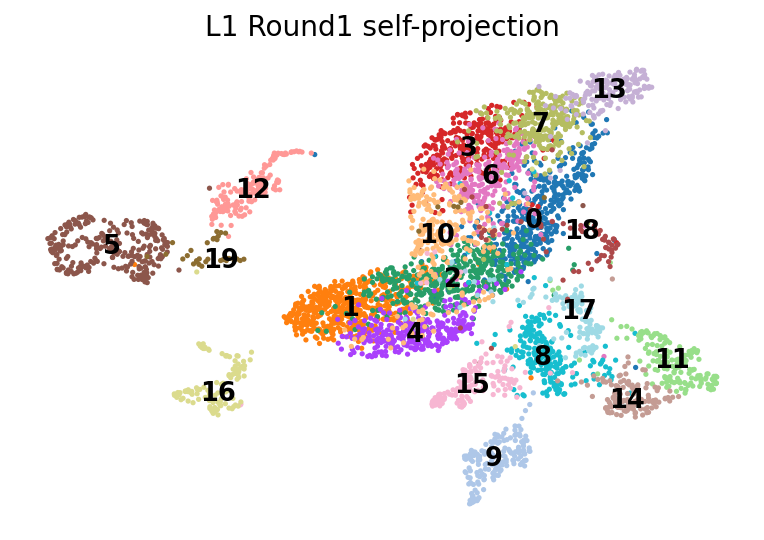

Accuracy on the training set: 0.9199
Accuracy on the hold-out set: 0.8202
Accuracy on the training set: 0.9149
Accuracy on the hold-out set: 0.8296
Max R1mat: 0.274194
Max R2mat: 0.025832
min_acc: 0.811867


<Figure size 432x288 with 0 Axes>

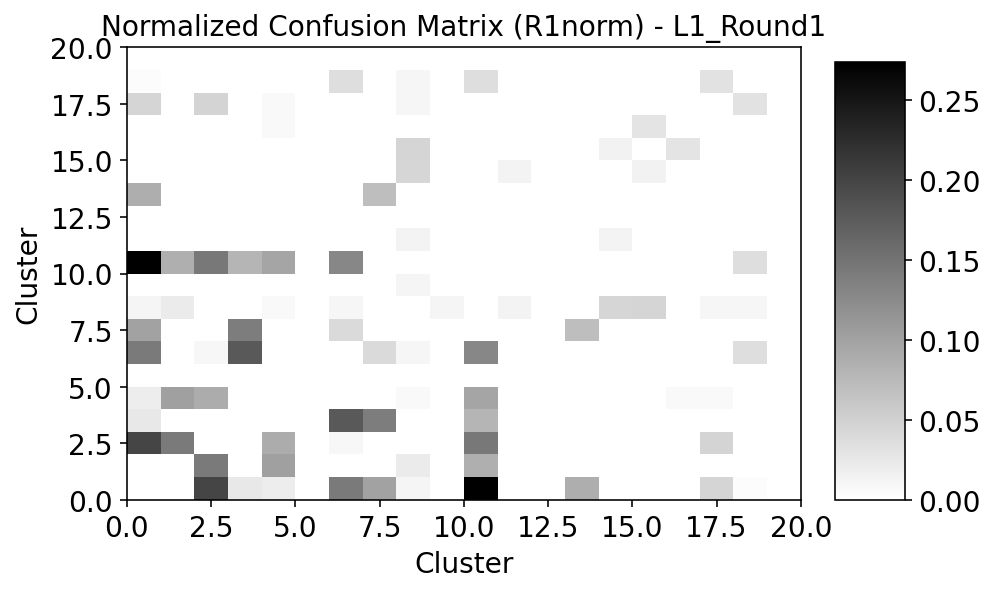

<Figure size 432x288 with 0 Axes>

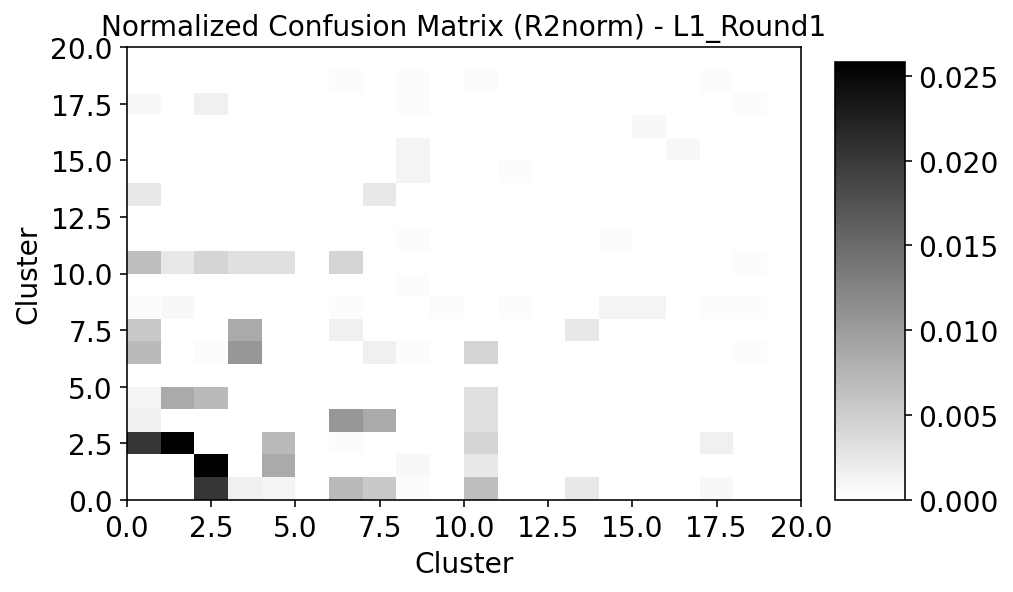

... storing 'L1_Round2' as categorical


IGRAPH U-W- 20 2 --
+ attr: weight (e)
+ edges:
0--10 0--10


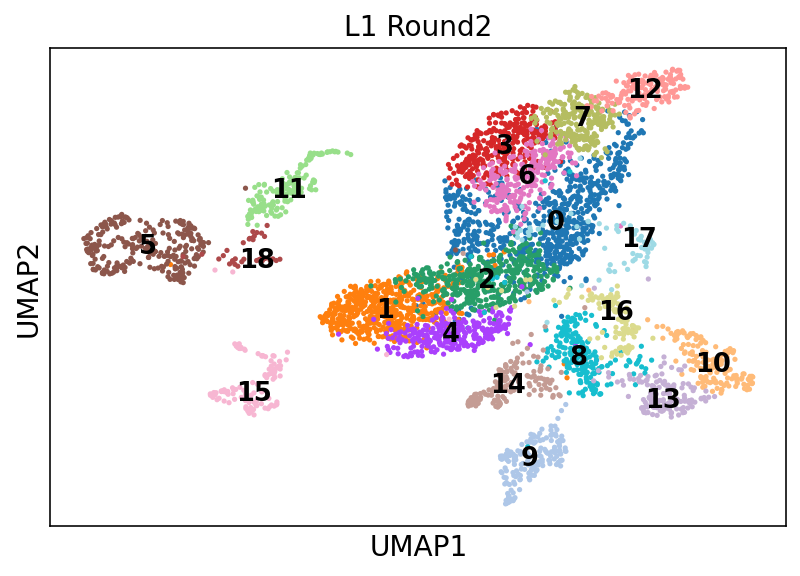

Round3 ...
Mean CV accuracy: 0.8569
Accuracy on the training set: 0.9288
Accuracy on the hold-out set: 0.7969


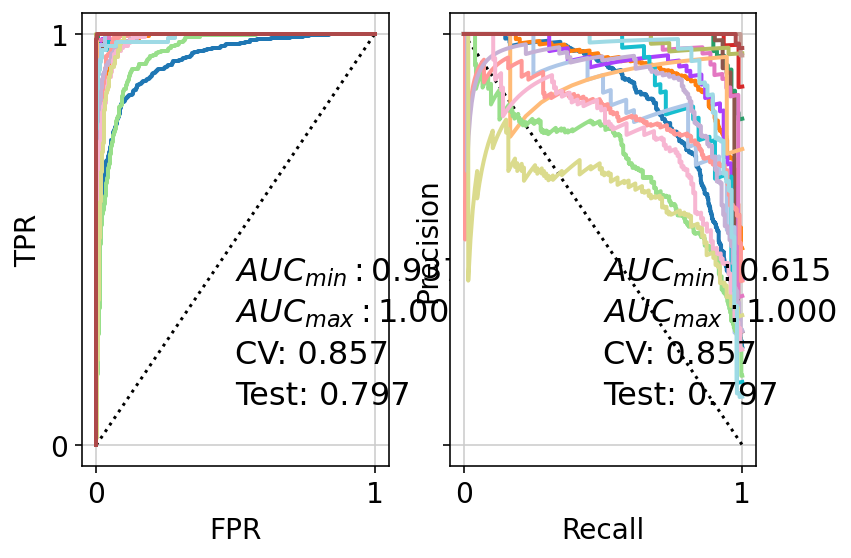

... storing 'L1_Round2_self-projection' as categorical


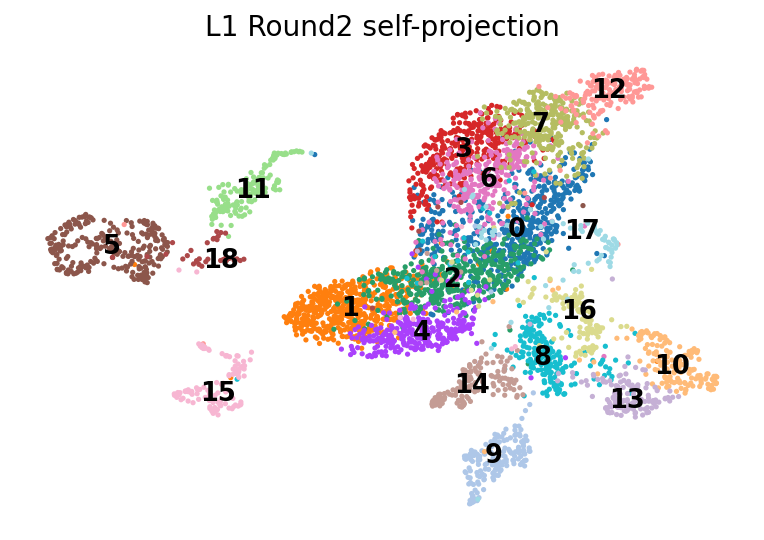

Accuracy on the training set: 0.9255
Accuracy on the hold-out set: 0.7934
Accuracy on the training set: 0.9175
Accuracy on the hold-out set: 0.8103
Max R1mat: 0.324324
Max R2mat: 0.027297
min_acc: 0.793394


<Figure size 432x288 with 0 Axes>

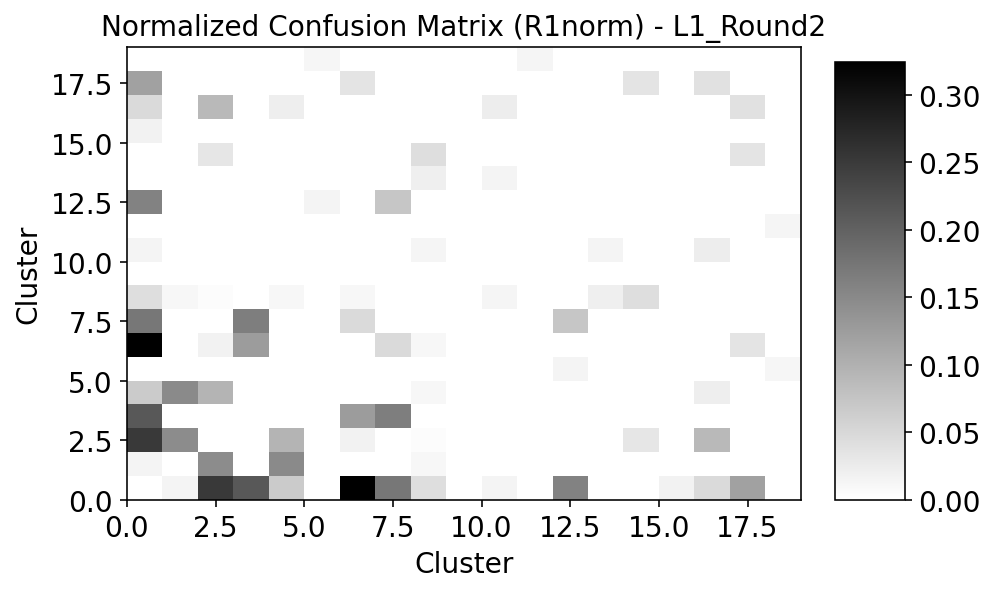

<Figure size 432x288 with 0 Axes>

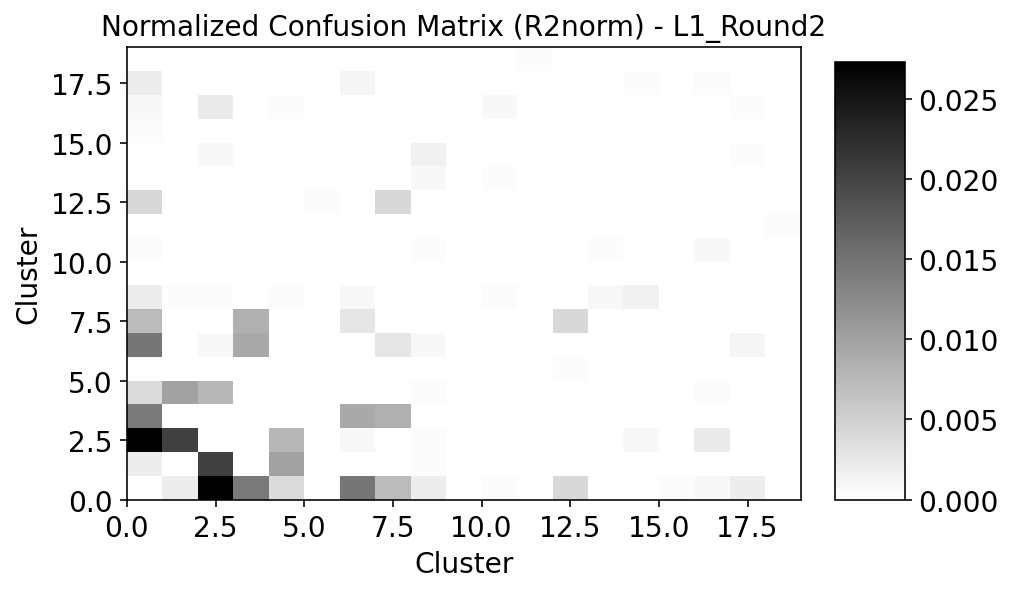

... storing 'L1_Round3' as categorical


IGRAPH U-W- 19 2 --
+ attr: weight (e)
+ edges:
0--6 0--6


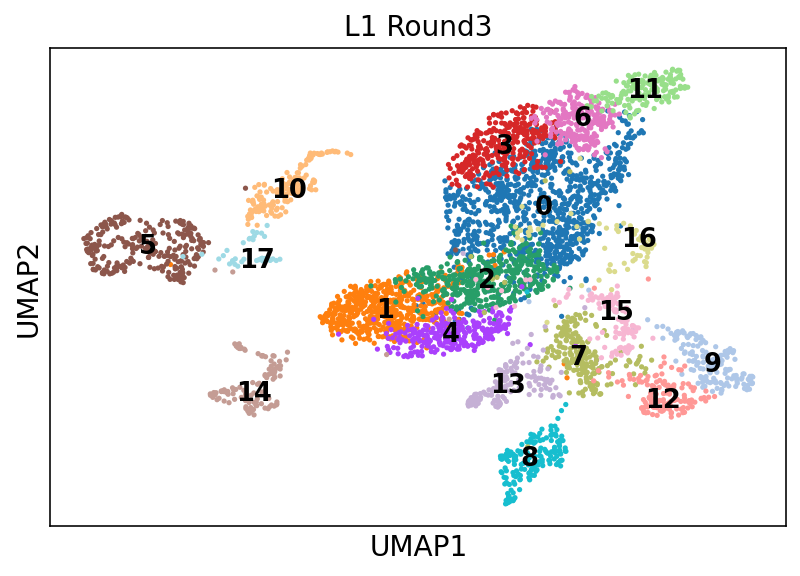

Round4 ...
Mean CV accuracy: 0.8637
Accuracy on the training set: 0.9350
Accuracy on the hold-out set: 0.7878


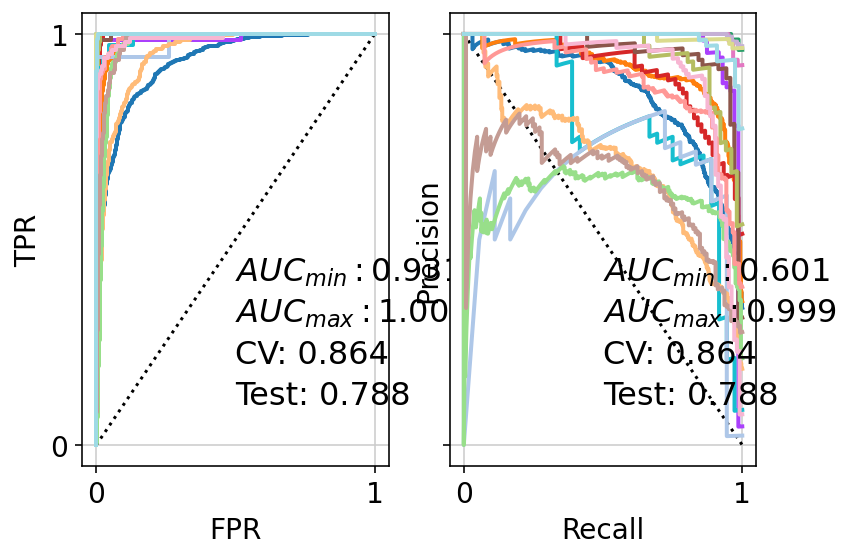

... storing 'L1_Round3_self-projection' as categorical


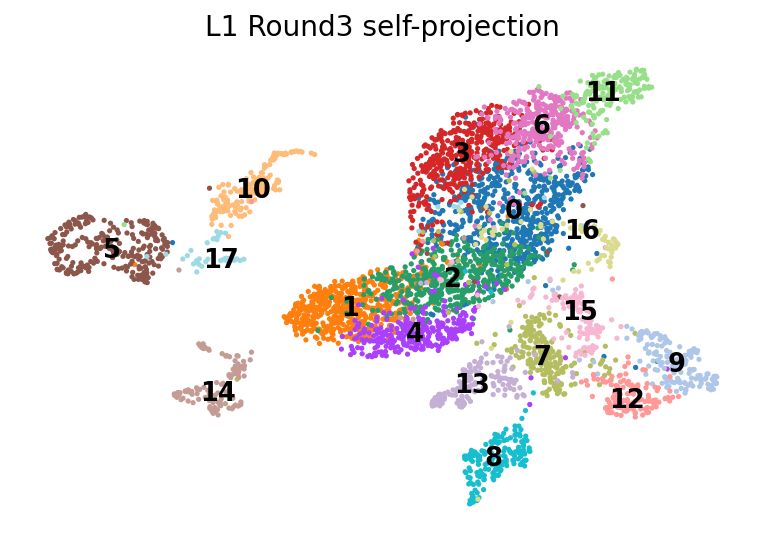

Accuracy on the training set: 0.9322
Accuracy on the hold-out set: 0.7763
Accuracy on the training set: 0.9393
Accuracy on the hold-out set: 0.7814
Max R1mat: 0.754902
Max R2mat: 0.036630
min_acc: 0.776307


<Figure size 432x288 with 0 Axes>

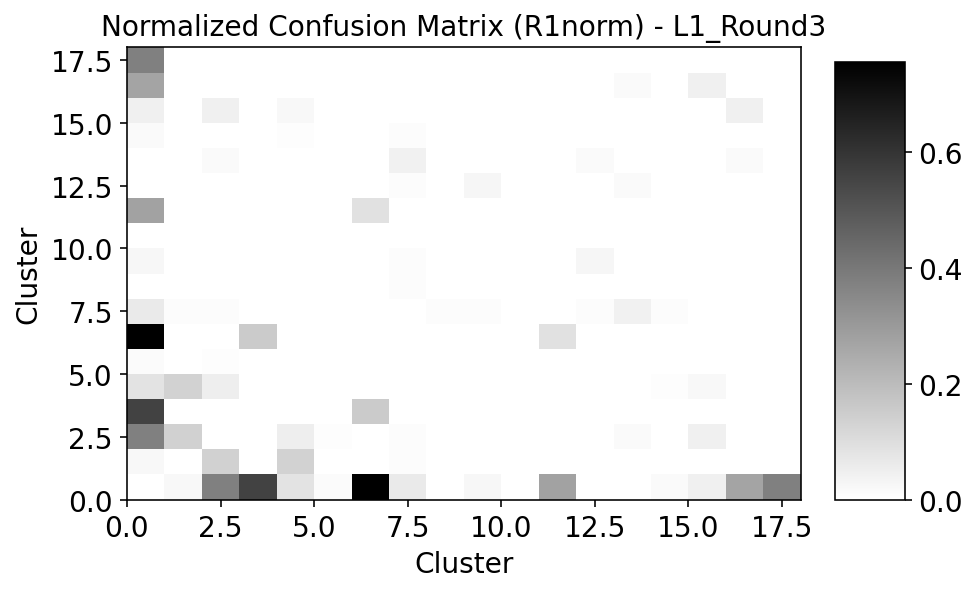

<Figure size 432x288 with 0 Axes>

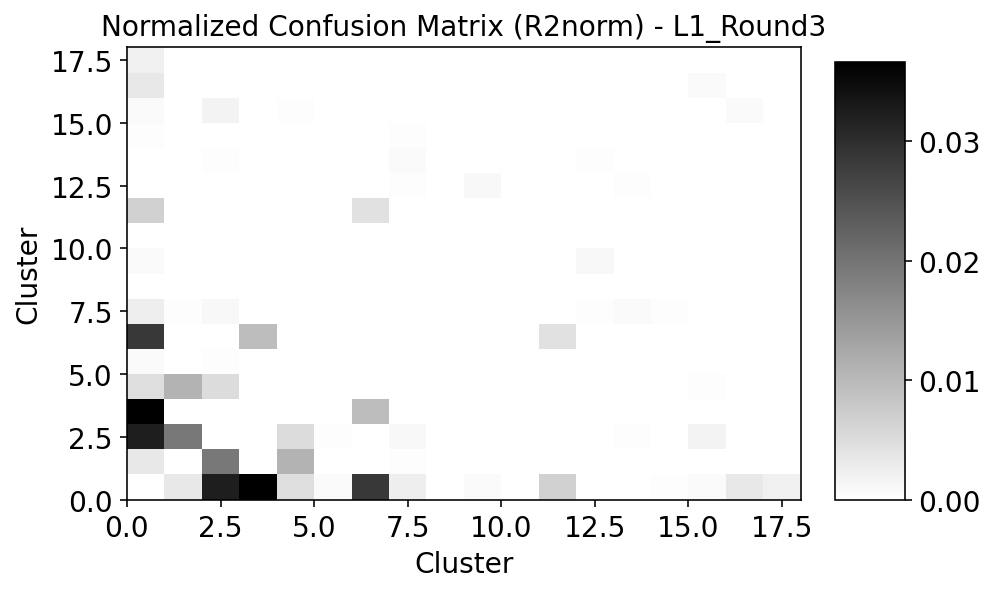

... storing 'L1_Round4' as categorical


IGRAPH U-W- 18 10 --
+ attr: weight (e)
+ edges:
0--2 0--3 0--6 0--11 0--16 0--2 0--3 0--6 0--11 0--16


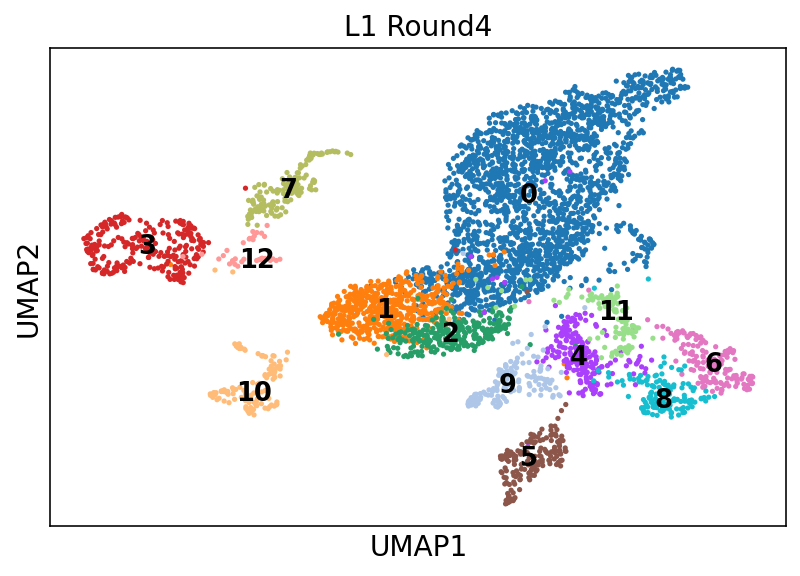

Round5 ...
Mean CV accuracy: 0.9353
Accuracy on the training set: 0.9682
Accuracy on the hold-out set: 0.8409


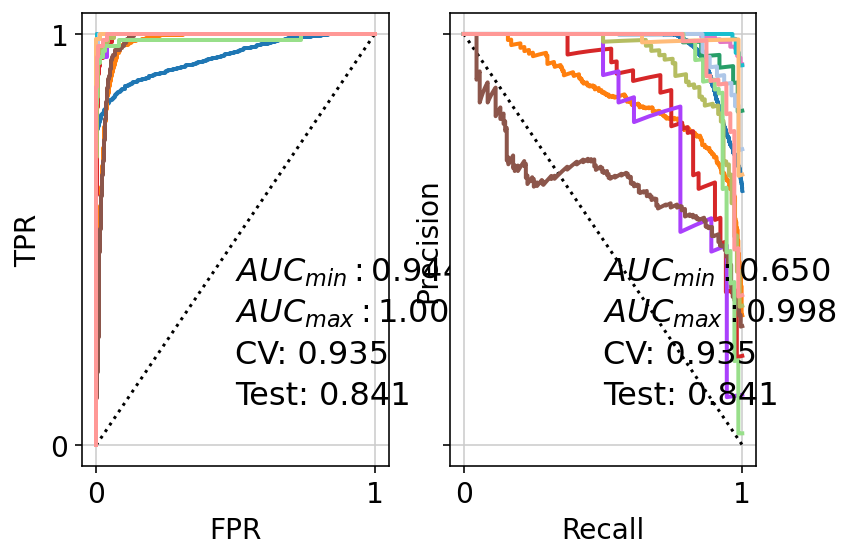

... storing 'L1_Round4_self-projection' as categorical


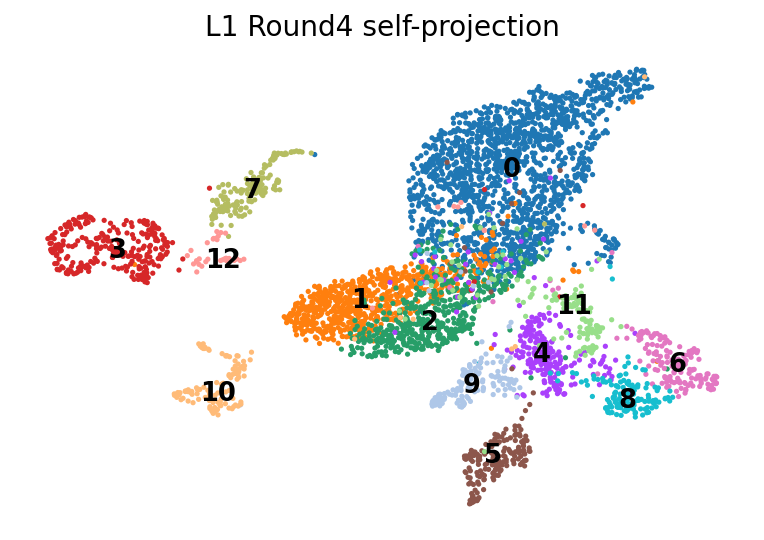

Accuracy on the training set: 0.9701
Accuracy on the hold-out set: 0.8573
Accuracy on the training set: 0.9602
Accuracy on the hold-out set: 0.8767
Max R1mat: 0.620915
Max R2mat: 0.040179
min_acc: 0.840929


<Figure size 432x288 with 0 Axes>

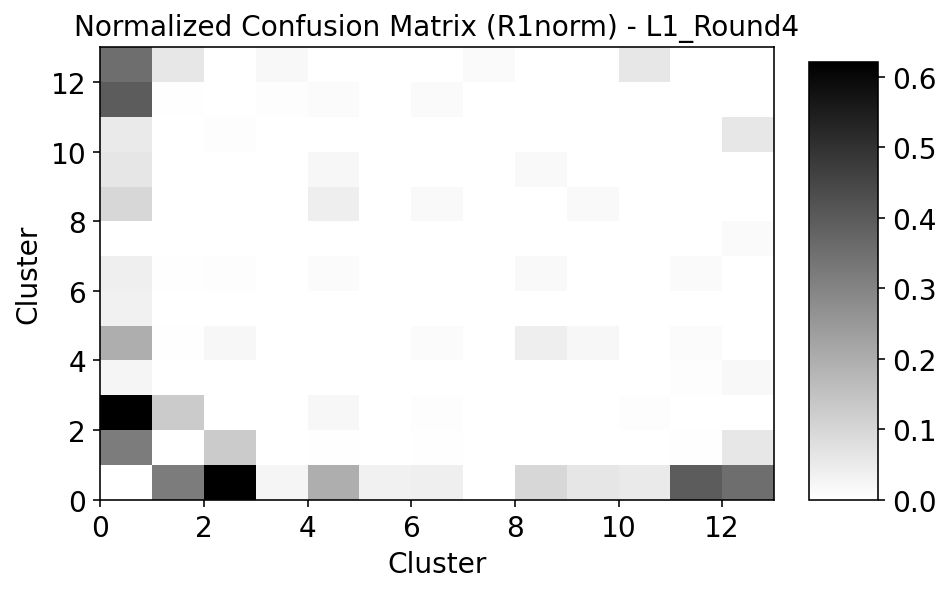

<Figure size 432x288 with 0 Axes>

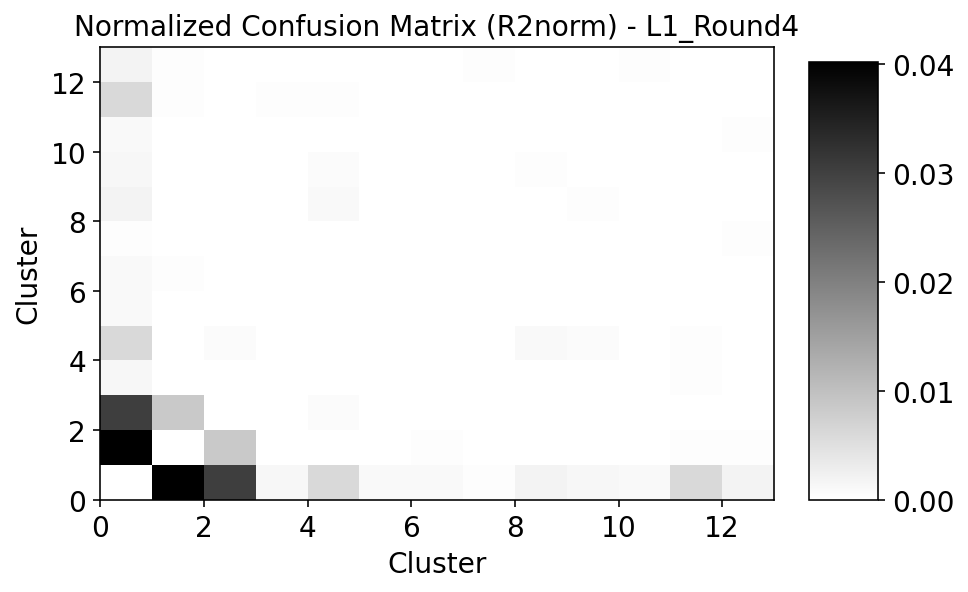

... storing 'L1_Round5' as categorical


IGRAPH U-W- 13 6 --
+ attr: weight (e)
+ edges:
0--1 0--2 0--11 0--1 0--2 0--11


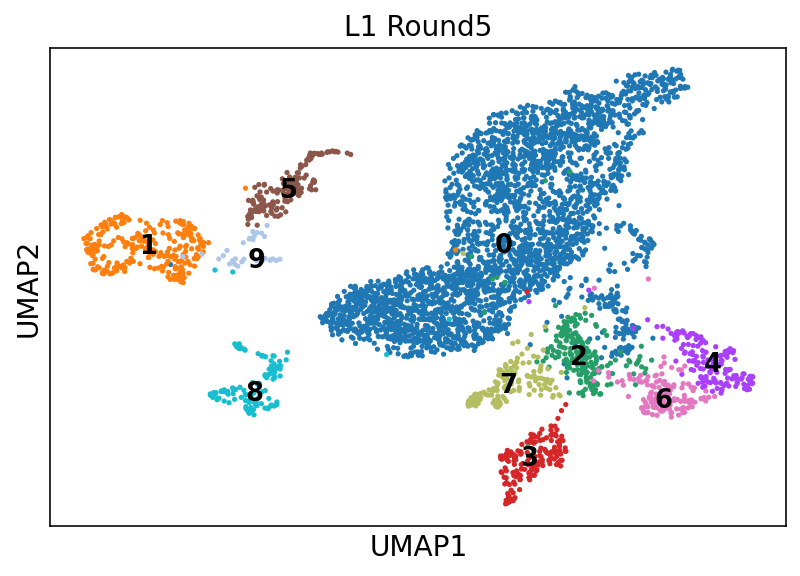

Round6 ...
Mean CV accuracy: 0.9337
Accuracy on the training set: 0.9761
Accuracy on the hold-out set: 0.7758


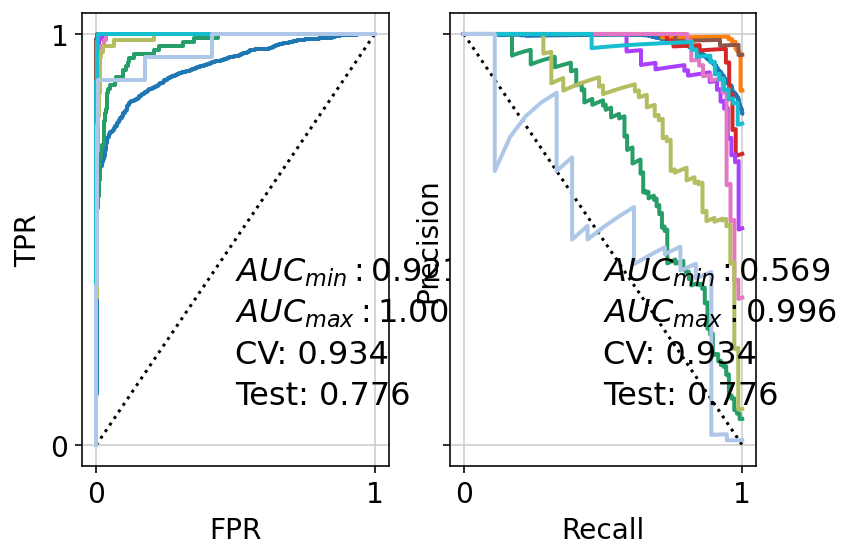

... storing 'L1_Round5_self-projection' as categorical


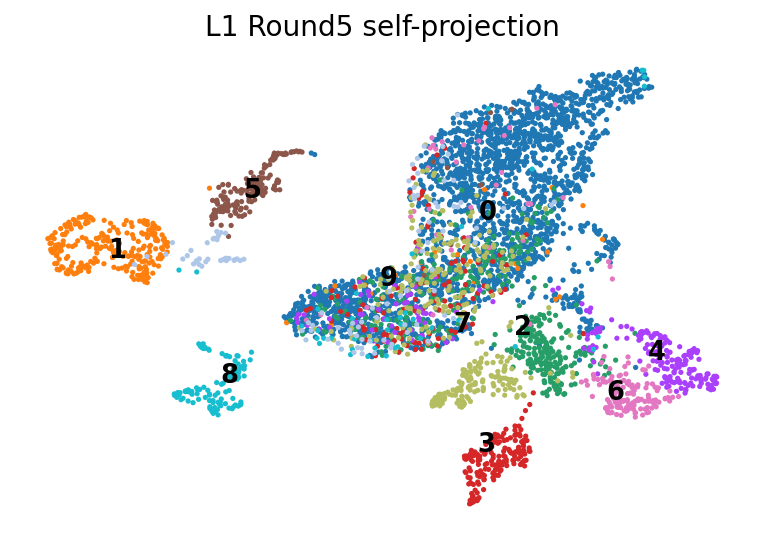

Accuracy on the training set: 0.9708
Accuracy on the hold-out set: 0.7988
Accuracy on the training set: 0.9761
Accuracy on the hold-out set: 0.8539
Max R1mat: 2.156250
Max R2mat: 0.063895
min_acc: 0.775776


<Figure size 432x288 with 0 Axes>

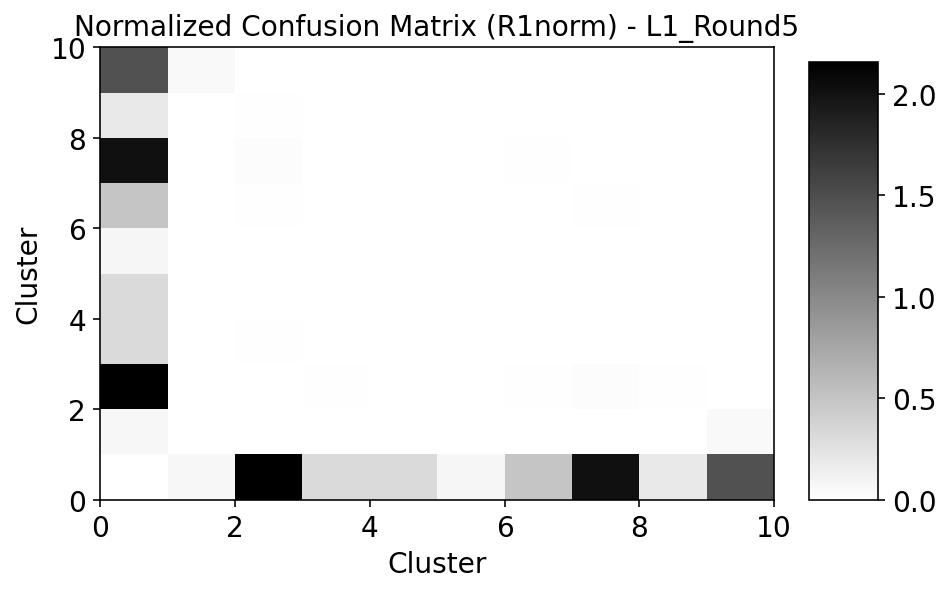

<Figure size 432x288 with 0 Axes>

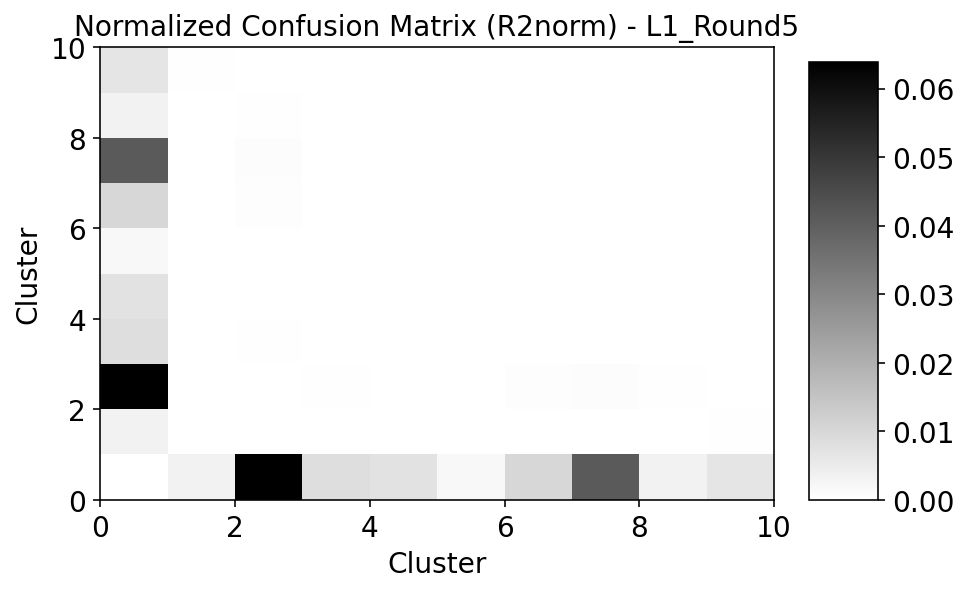

IGRAPH U-W- 10 0 --
+ attr: weight (e)
Converge SCCAF_optimize no. cluster!
m1: 2.156250
m2: 0.063895
Accuracy: 0.775776
start_iter: 5
R1norm_cutoff: 2.146250
R2norm_cutoff: 0.062895
Accuracy: 0.775776
Round6 ...
Mean CV accuracy: 0.9151
Accuracy on the training set: 0.9788
Accuracy on the hold-out set: 0.8459


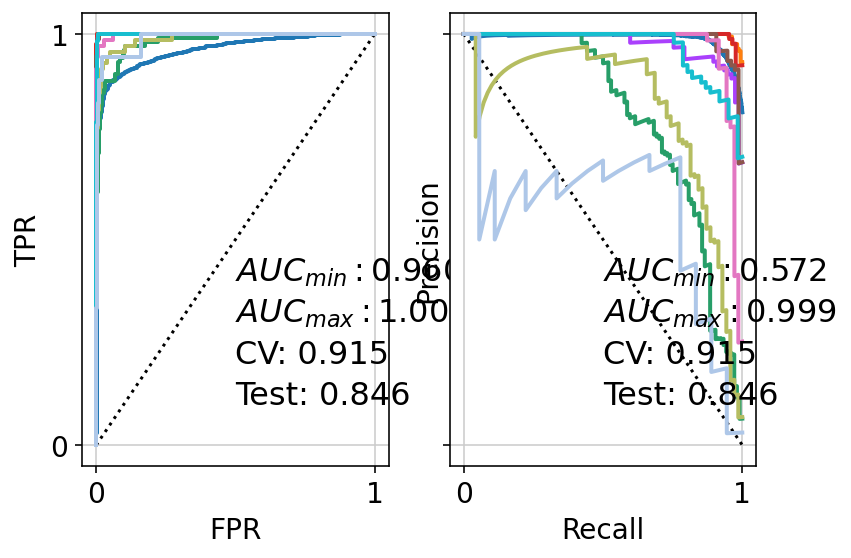

... storing 'L1_Round5_self-projection' as categorical


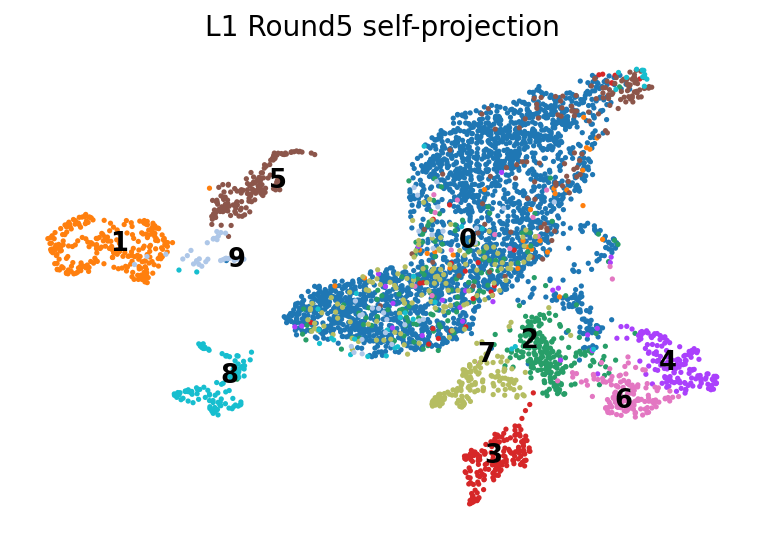

Accuracy on the training set: 0.9695
Accuracy on the hold-out set: 0.7650
Accuracy on the training set: 0.9814
Accuracy on the hold-out set: 0.8914
Max R1mat: 1.588235
Max R2mat: 0.035204
min_acc: 0.764967


<Figure size 432x288 with 0 Axes>

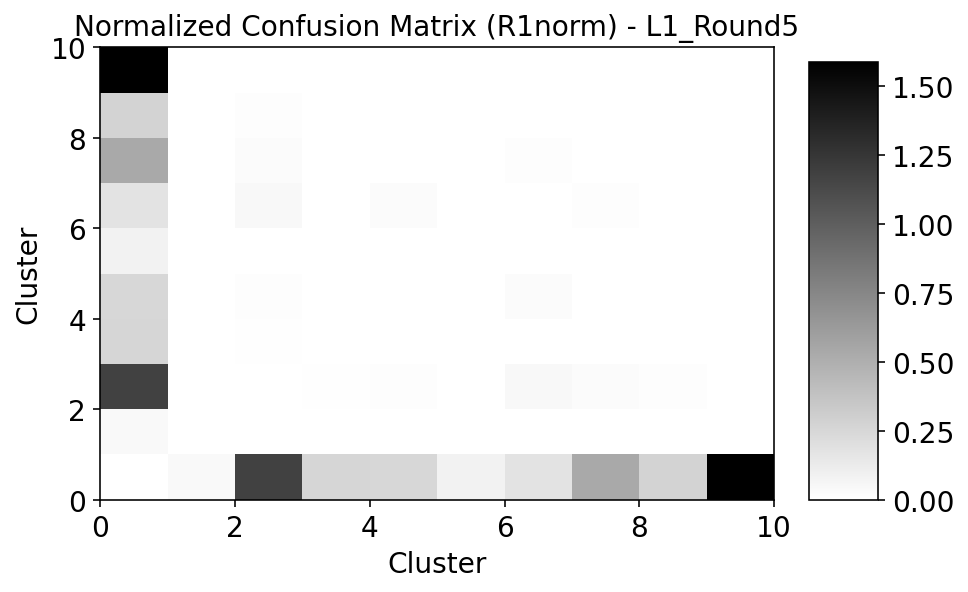

<Figure size 432x288 with 0 Axes>

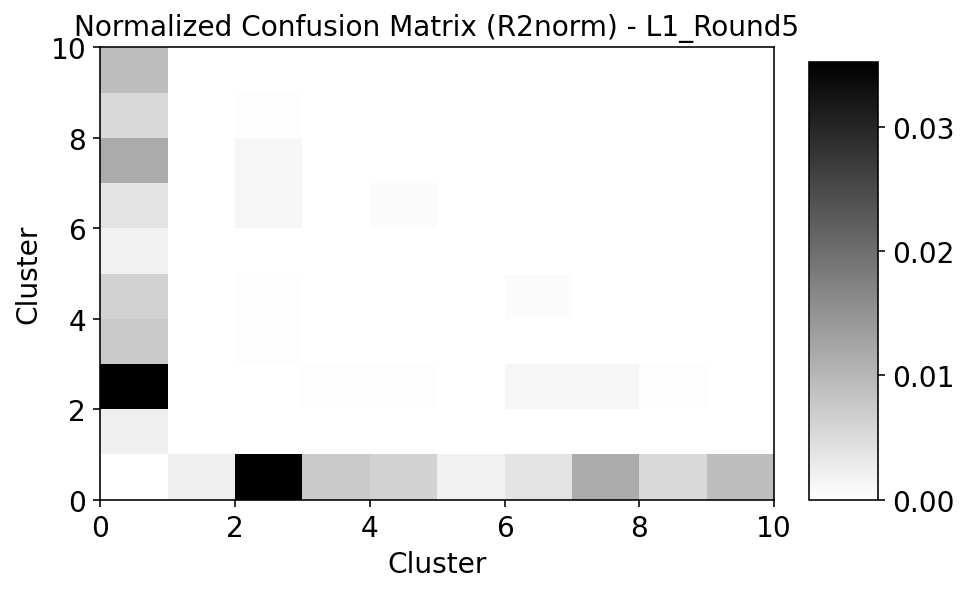

IGRAPH U-W- 10 0 --
+ attr: weight (e)
Converge SCCAF_optimize no. cluster!
m1: 1.588235
m2: 0.035204
Accuracy: 0.764967
start_iter: 5
R1norm_cutoff: 1.578235
R2norm_cutoff: 0.034204
Accuracy: 0.764967
Round6 ...
Mean CV accuracy: 0.9178
Accuracy on the training set: 0.9867
Accuracy on the hold-out set: 0.8401


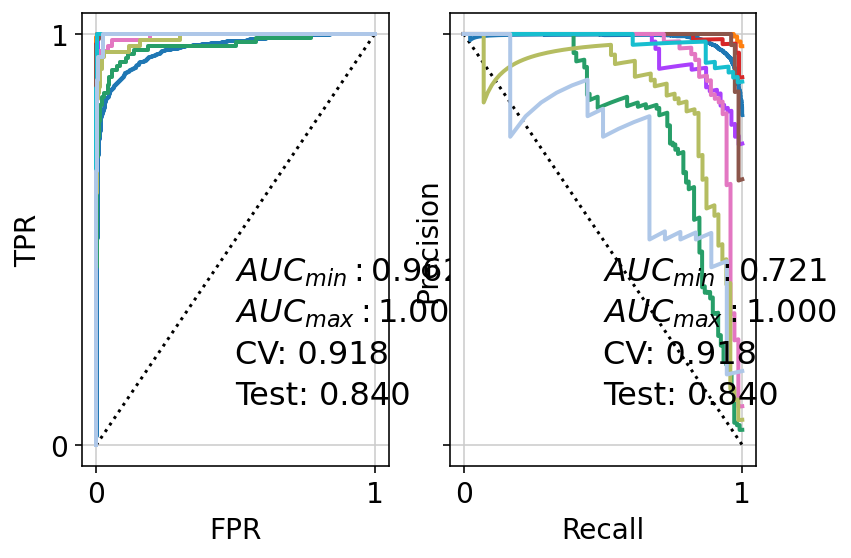

... storing 'L1_Round5_self-projection' as categorical


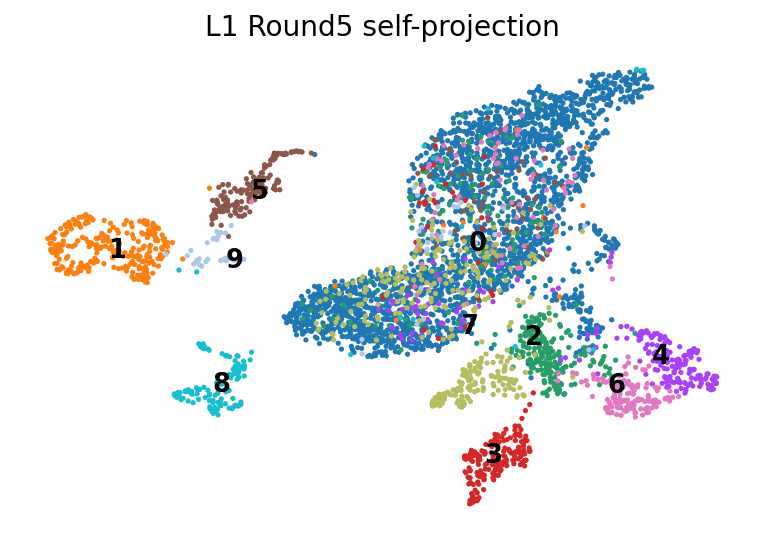

Accuracy on the training set: 0.9788
Accuracy on the hold-out set: 0.8354
Accuracy on the training set: 0.9801
Accuracy on the hold-out set: 0.8417
Max R1mat: 1.500000
Max R2mat: 0.040108
min_acc: 0.835366


<Figure size 432x288 with 0 Axes>

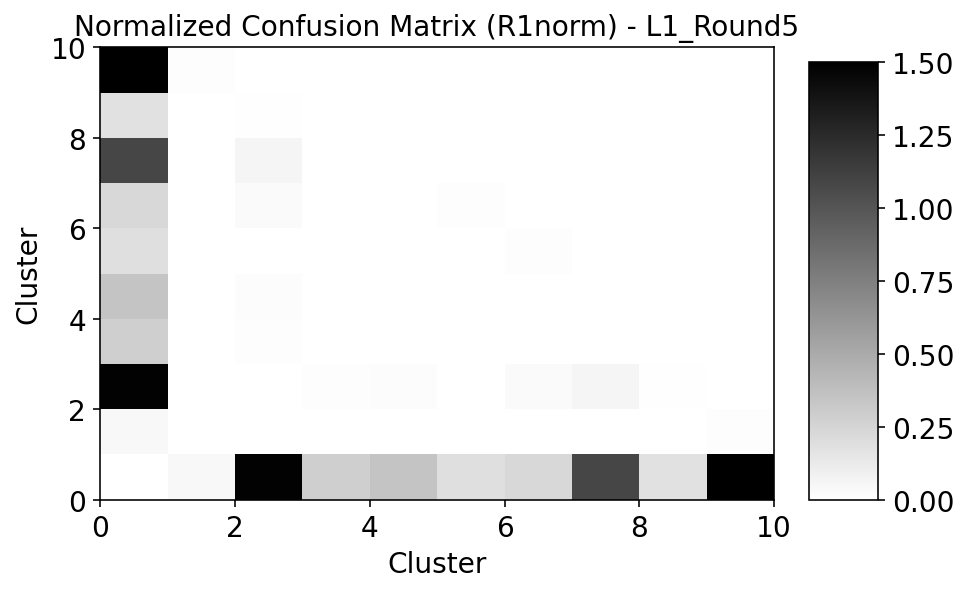

<Figure size 432x288 with 0 Axes>

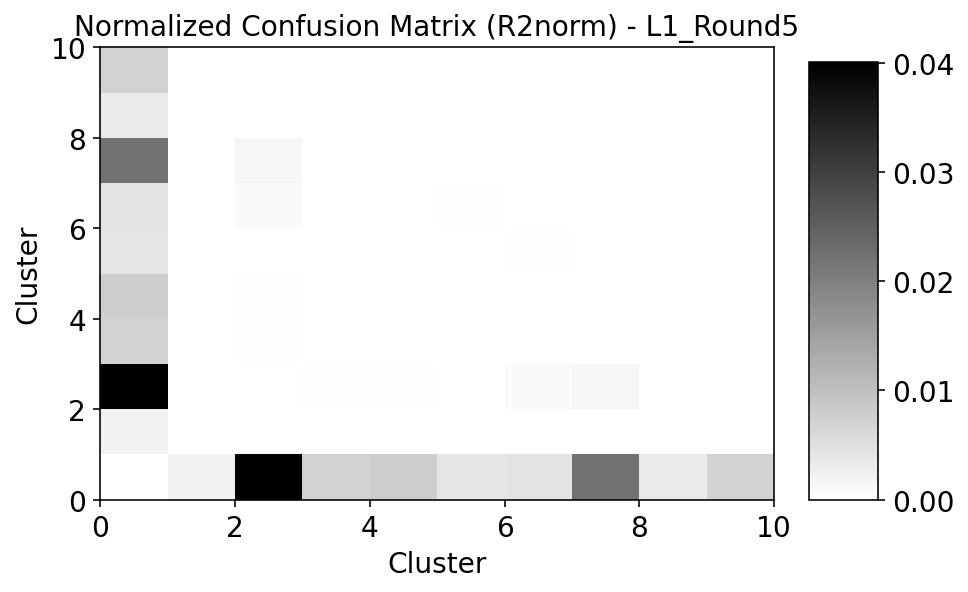

IGRAPH U-W- 10 0 --
+ attr: weight (e)
Converge SCCAF_optimize no. cluster!
m1: 1.500000
m2: 0.040108
Accuracy: 0.835366
start_iter: 5
R1norm_cutoff: 1.490000
R2norm_cutoff: 0.039108
Accuracy: 0.835366
Round6 ...
Mean CV accuracy: 0.9310
Accuracy on the training set: 0.9801
Accuracy on the hold-out set: 0.8473


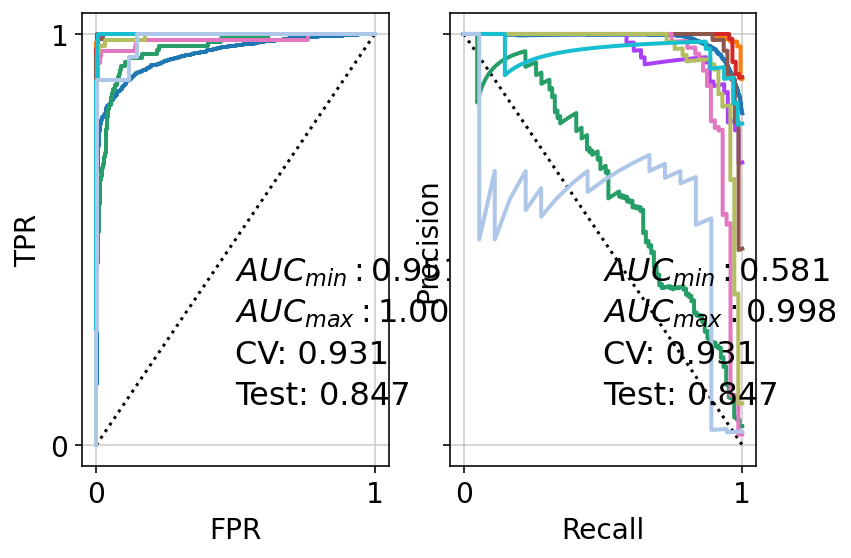

... storing 'L1_Round5_self-projection' as categorical


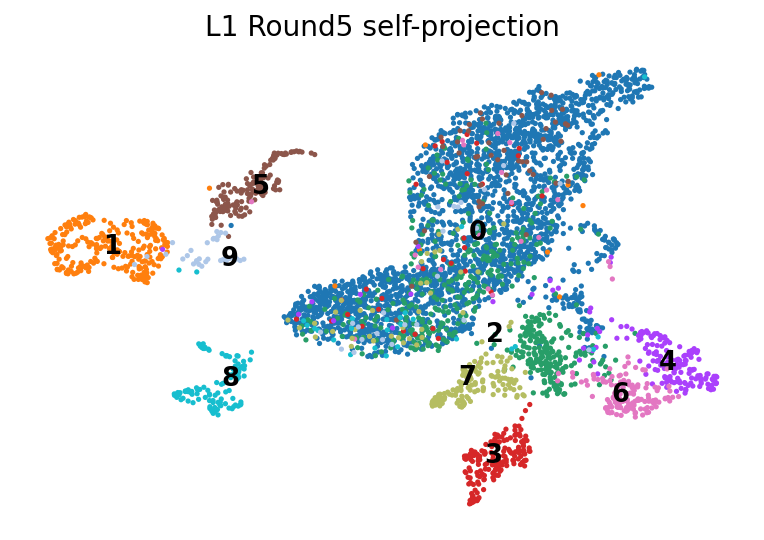

Accuracy on the training set: 0.9788
Accuracy on the hold-out set: 0.8866
Accuracy on the training set: 0.9801
Accuracy on the hold-out set: 0.8503
Max R1mat: 1.588235
Max R2mat: 0.034525
min_acc: 0.847284


<Figure size 432x288 with 0 Axes>

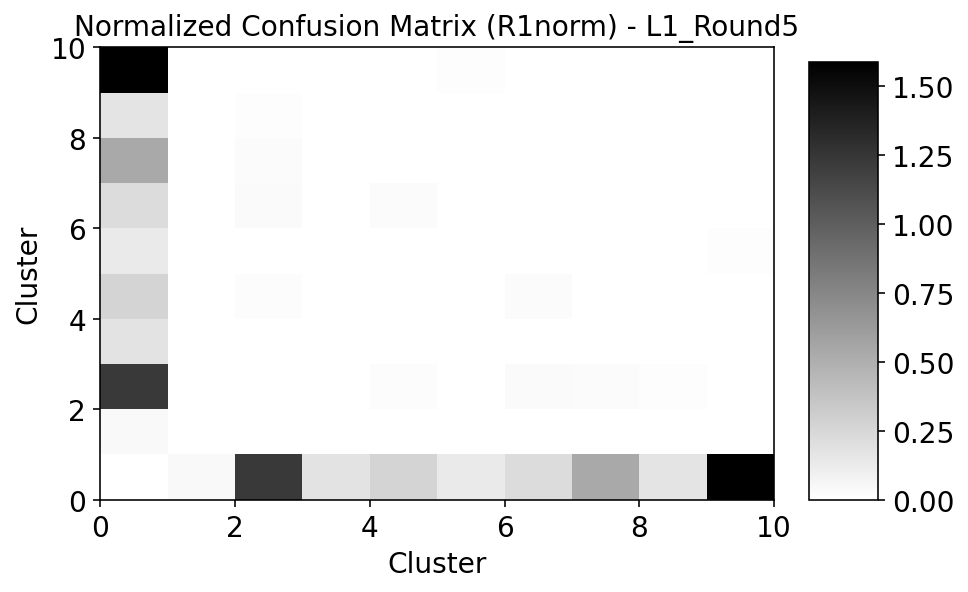

<Figure size 432x288 with 0 Axes>

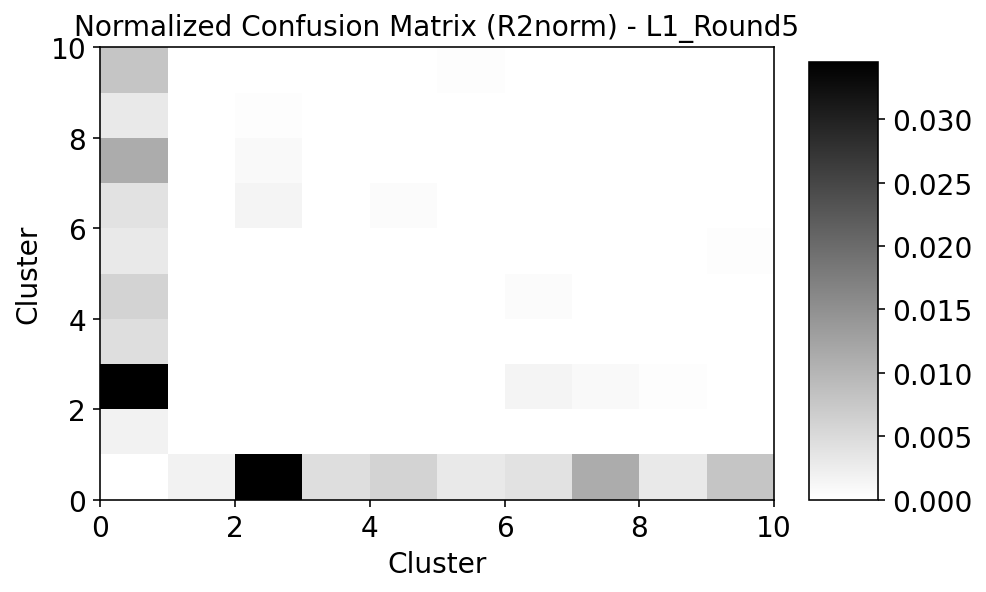

IGRAPH U-W- 10 0 --
+ attr: weight (e)
Converge SCCAF_optimize no. cluster!
m1: 1.588235
m2: 0.034525
Accuracy: 0.847284
start_iter: 5
R1norm_cutoff: 1.578235
R2norm_cutoff: 0.033525
Accuracy: 0.847284
Round6 ...
Mean CV accuracy: 0.9257
Accuracy on the training set: 0.9788
Accuracy on the hold-out set: 0.8631


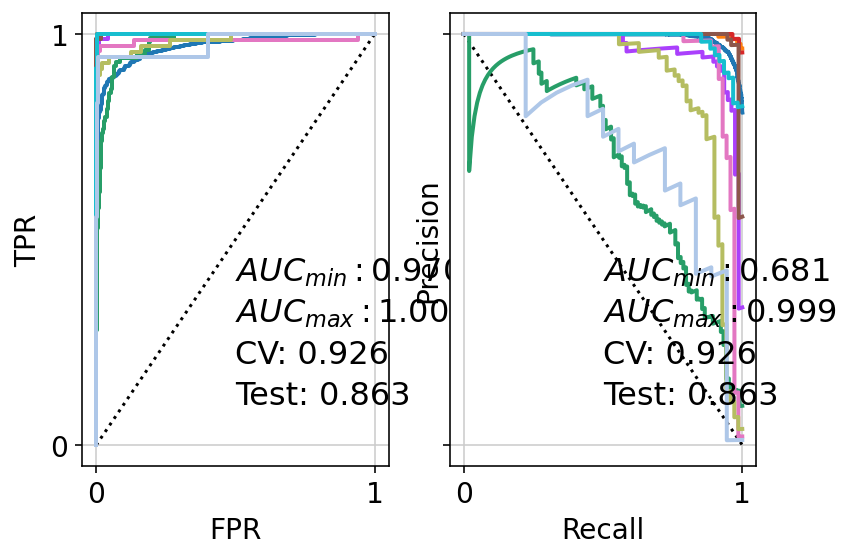

... storing 'L1_Round5_self-projection' as categorical


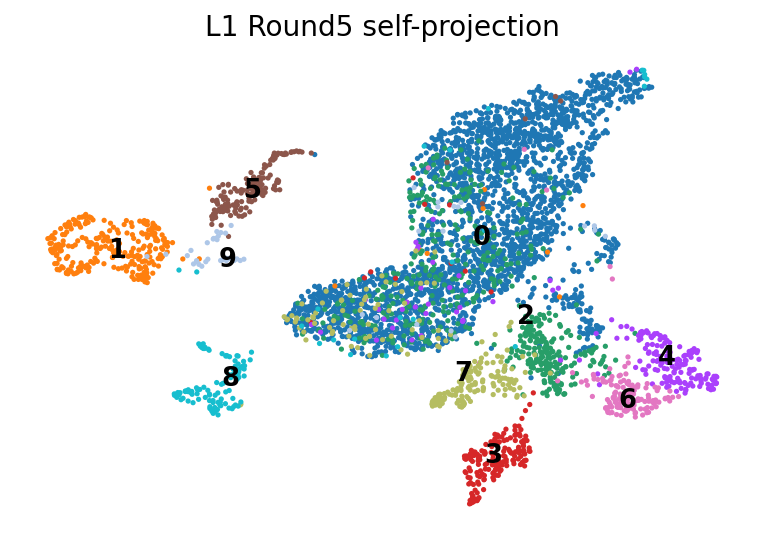

Accuracy on the training set: 0.9814
Accuracy on the hold-out set: 0.8412
Accuracy on the training set: 0.9761
Accuracy on the hold-out set: 0.8146
Max R1mat: 3.103093
Max R2mat: 0.089690
min_acc: 0.814579


<Figure size 432x288 with 0 Axes>

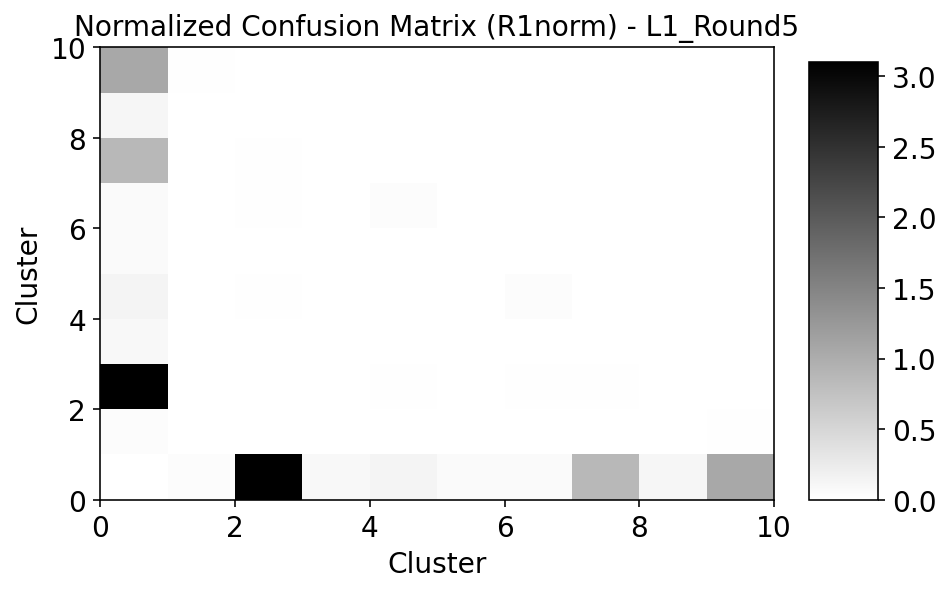

<Figure size 432x288 with 0 Axes>

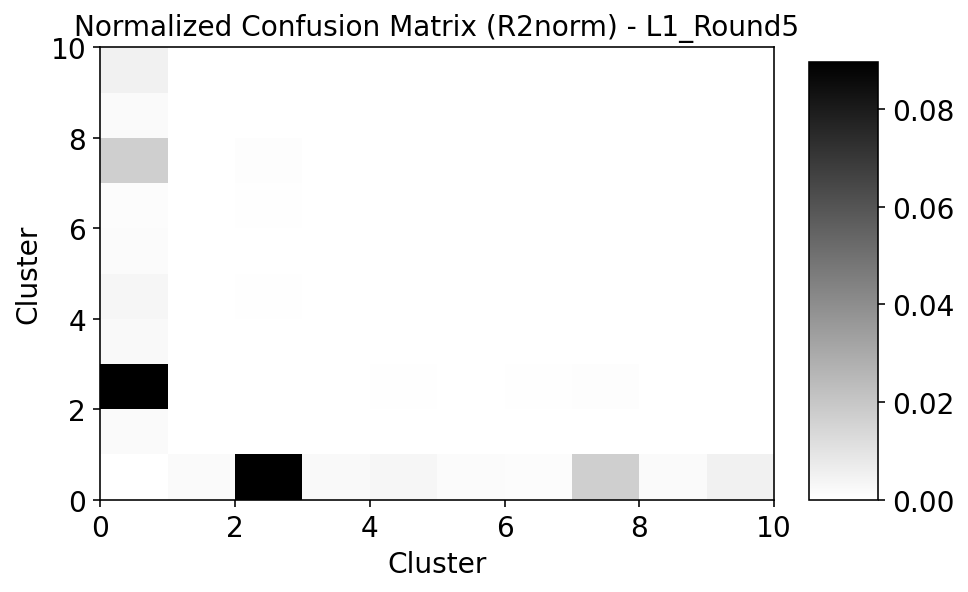

IGRAPH U-W- 10 0 --
+ attr: weight (e)
Converge SCCAF_optimize no. cluster!
m1: 3.103093
m2: 0.089690
Accuracy: 0.814579
start_iter: 5
R1norm_cutoff: 3.093093
R2norm_cutoff: 0.088690
Accuracy: 0.814579
Round6 ...
Mean CV accuracy: 0.9377
Accuracy on the training set: 0.9814
Accuracy on the hold-out set: 0.8670


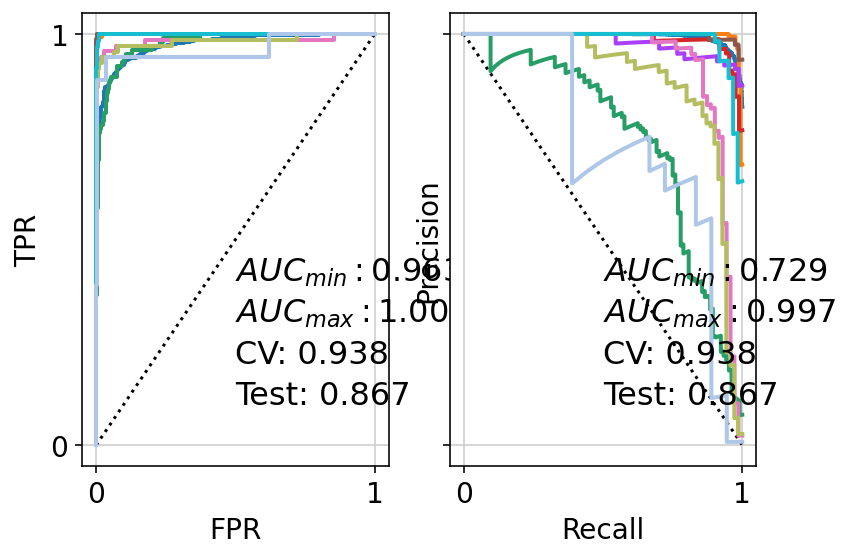

... storing 'L1_Round5_self-projection' as categorical


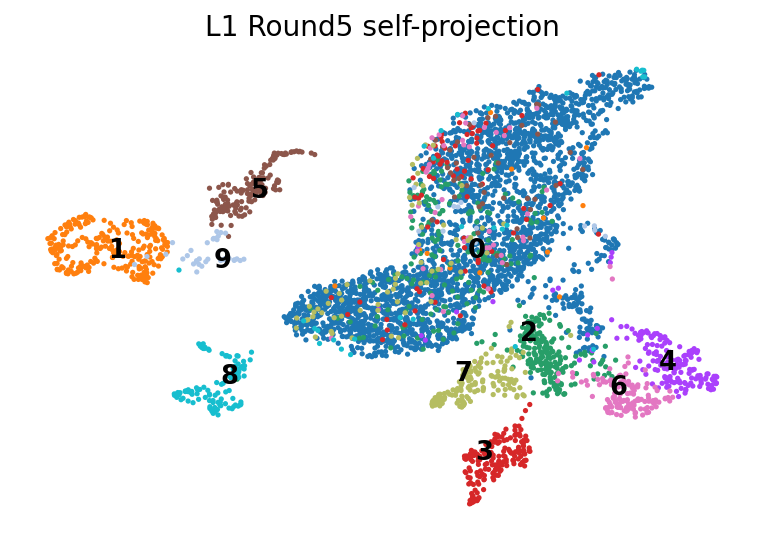

Accuracy on the training set: 0.9788
Accuracy on the hold-out set: 0.8453
Accuracy on the training set: 0.9788
Accuracy on the hold-out set: 0.8692
Max R1mat: 1.473118
Max R2mat: 0.042055
min_acc: 0.845344


<Figure size 432x288 with 0 Axes>

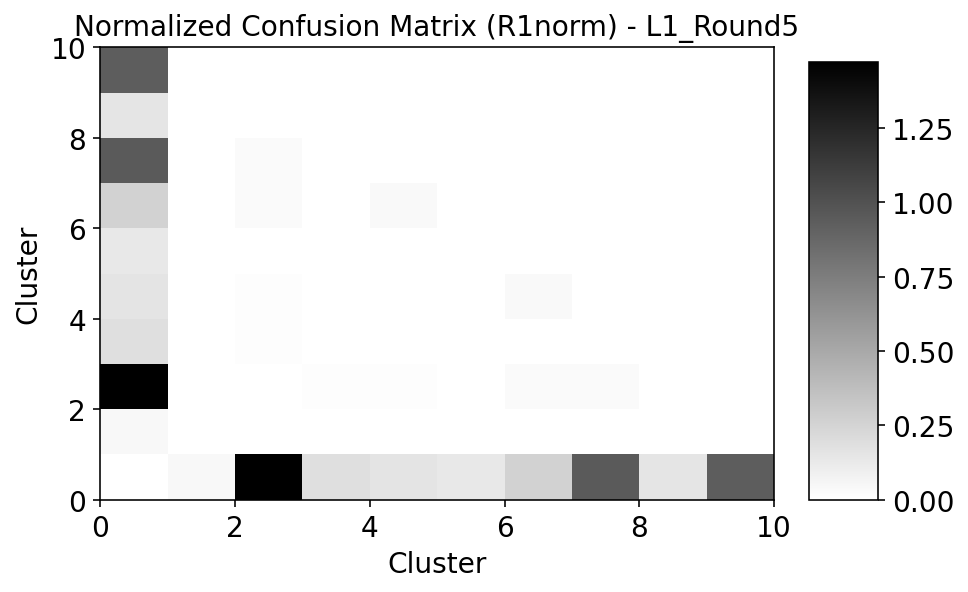

<Figure size 432x288 with 0 Axes>

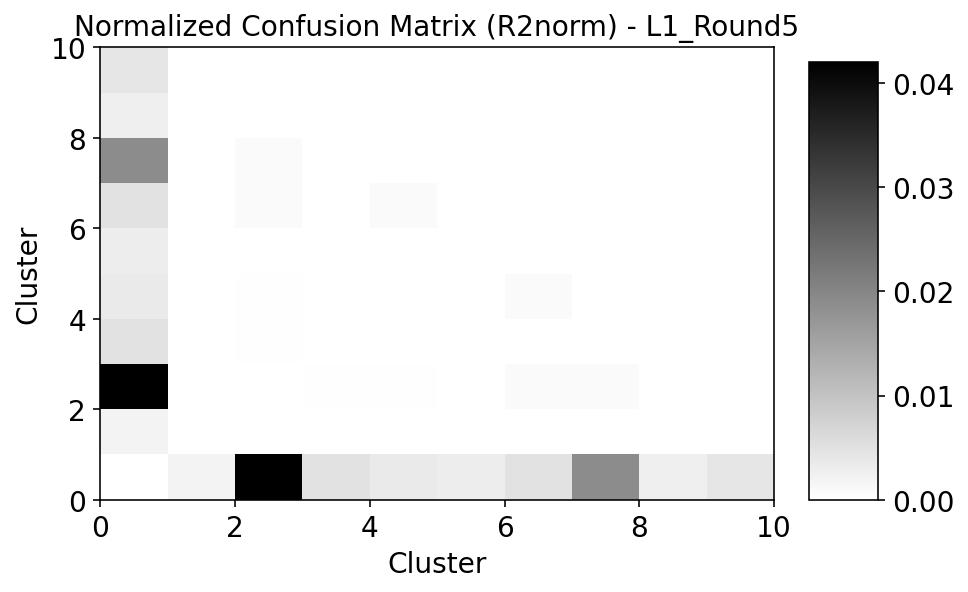

IGRAPH U-W- 10 0 --
+ attr: weight (e)
Converge SCCAF_optimize no. cluster!
m1: 1.473118
m2: 0.042055
Accuracy: 0.845344
start_iter: 5
R1norm_cutoff: 1.463118
R2norm_cutoff: 0.041055
Accuracy: 0.845344
Round6 ...
Mean CV accuracy: 0.9350
Accuracy on the training set: 0.9788
Accuracy on the hold-out set: 0.8240


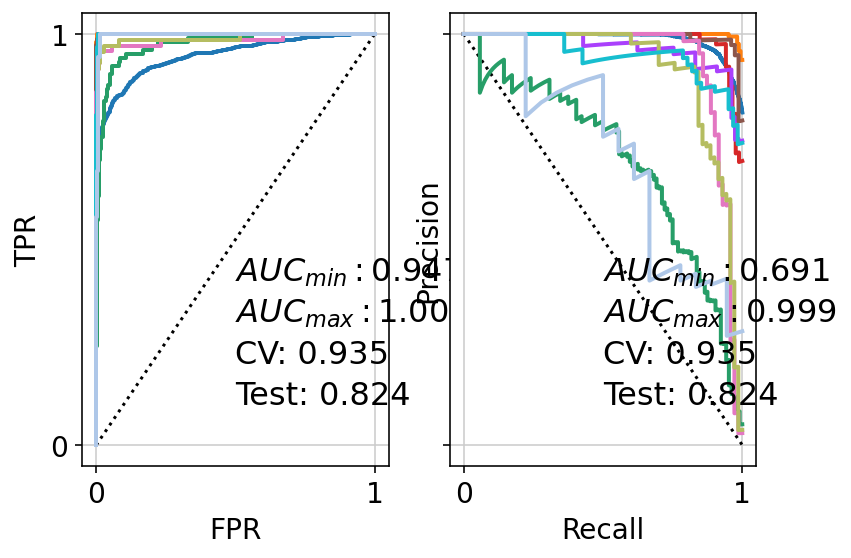

... storing 'L1_Round5_self-projection' as categorical


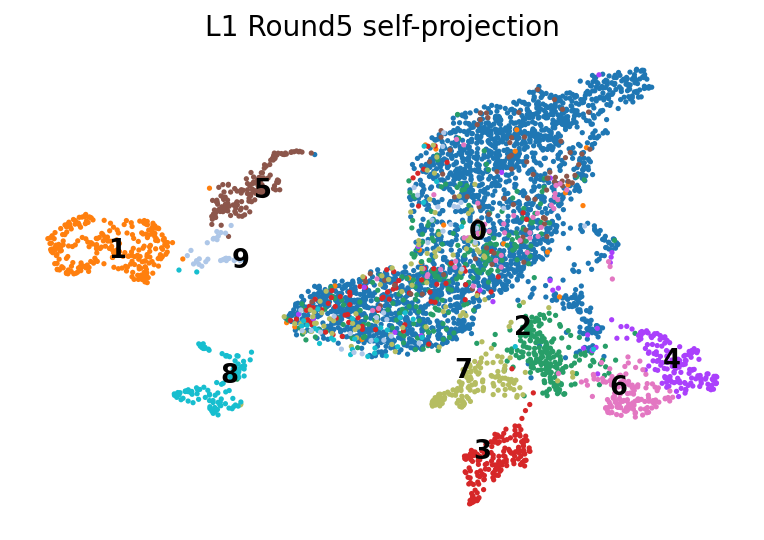

Accuracy on the training set: 0.9708
Accuracy on the hold-out set: 0.8135
Accuracy on the training set: 0.9854
Accuracy on the hold-out set: 0.8373
Max R1mat: 2.275510
Max R2mat: 0.066172
min_acc: 0.813470


<Figure size 432x288 with 0 Axes>

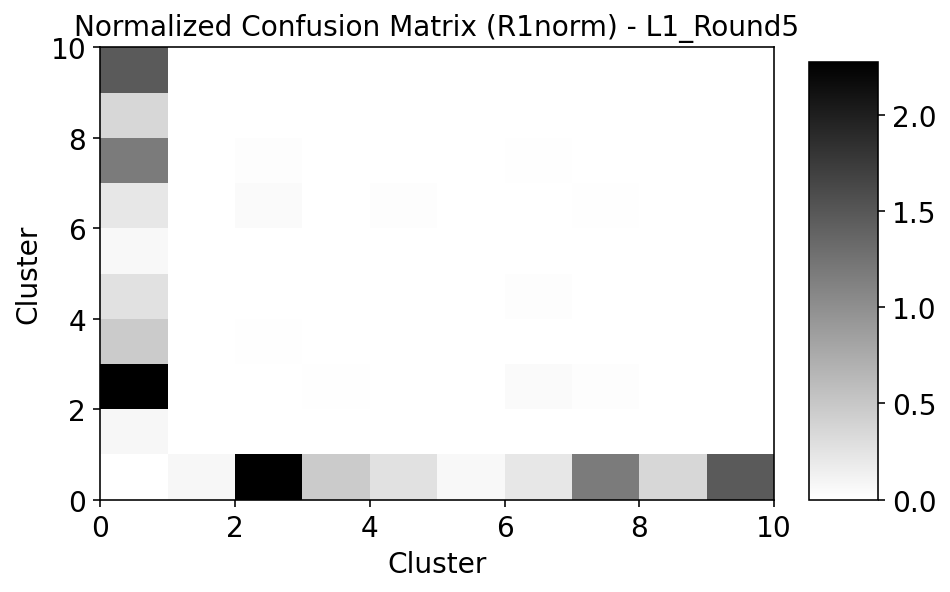

<Figure size 432x288 with 0 Axes>

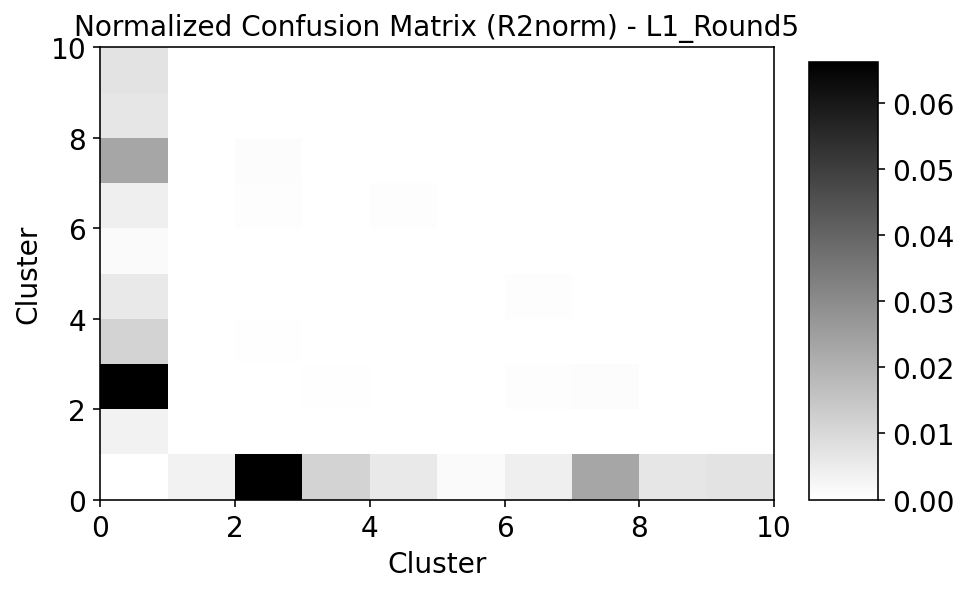

IGRAPH U-W- 10 0 --
+ attr: weight (e)
Converge SCCAF_optimize no. cluster!
m1: 2.275510
m2: 0.066172
Accuracy: 0.813470


In [93]:
SCCAF_optimize_all(min_acc=0.90, ad=adata, use='pca', basis='umap',low_res = 'louvain_r0.2')

In [94]:
adata.write("write/ica_all_reg.h5")

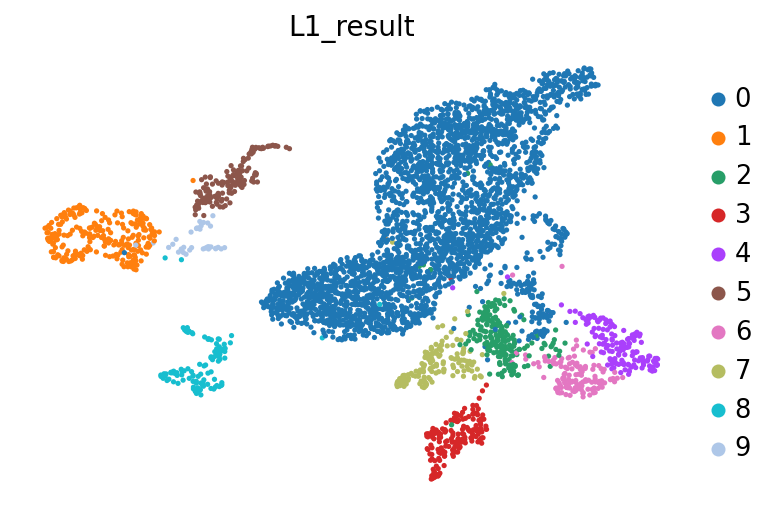

In [95]:
sc.pl.umap(adata,color=['L1_result'], frameon=False)

Mean CV accuracy: 0.8846
Accuracy on the training set: 0.9987
Accuracy on the hold-out set: 0.7059


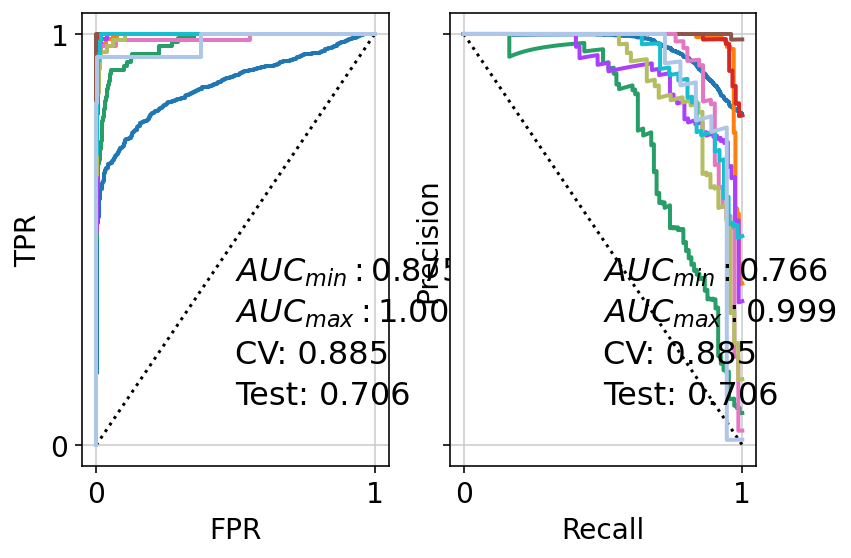

In [96]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['L1_result'],n=100)
aucs = plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.show()

In [97]:
topmarkers = get_topmarkers(clf=clf, names=adata.var_names, topn=30)

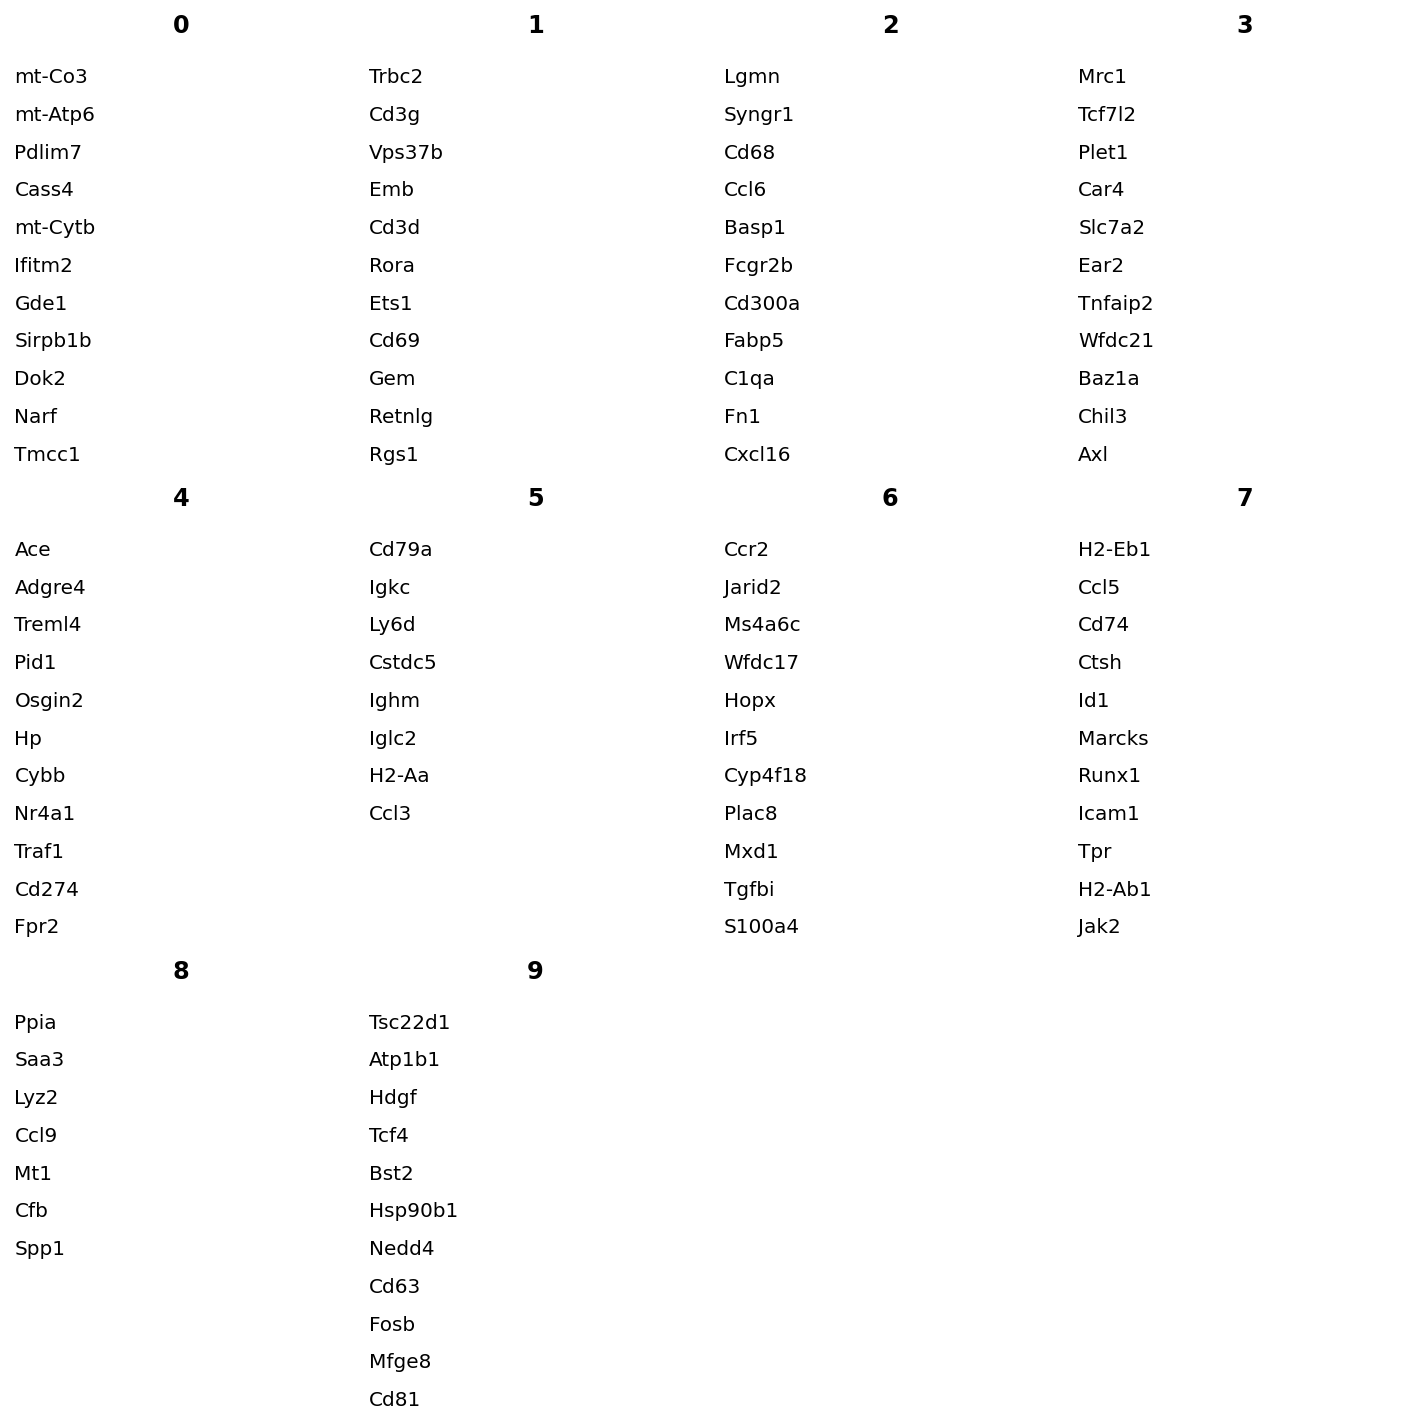

In [98]:
figsize(10,10)
plot_markers(top_markers=topmarkers)

In [114]:
marker_genes = ['mt-Atp6','mt-Co3','Pdlim7','Cass4','Trbc2','Cd3g','Vps37b','Emb','Cd3d','Lgmn','Syngr1',
'Cd68','Ccl6','Basp1','Mrc1','Tcf7l2','Plet1','Car4','Slc7a2','Ace','Adgre4','Treml4','Pid1','Osgin2',
'Cd79a','Igkc','Ly6d','Cstdc5','Ighm','Ccr2','Jarid2','Ms4a6c','Wfdc17','Hopx','H2-Eb1','Ccl5','Cd74',
'Ctsh','Id1','Ppia','Saa3','Lyz2','Ccl9','Mt1','Atp1b1','Hdgf','Tcf4','Bst2','Hsp90b1']

In [115]:
new_cluster_names = ['Macrophages', 'Macrophages2', 'Macrophages3', 'Macrophages4','Macrophages5', 'B-cells','Macrophages6',
    'B-cells2','Macrophages7','Mast Cells']
adata.rename_categories('L1_result', new_cluster_names)

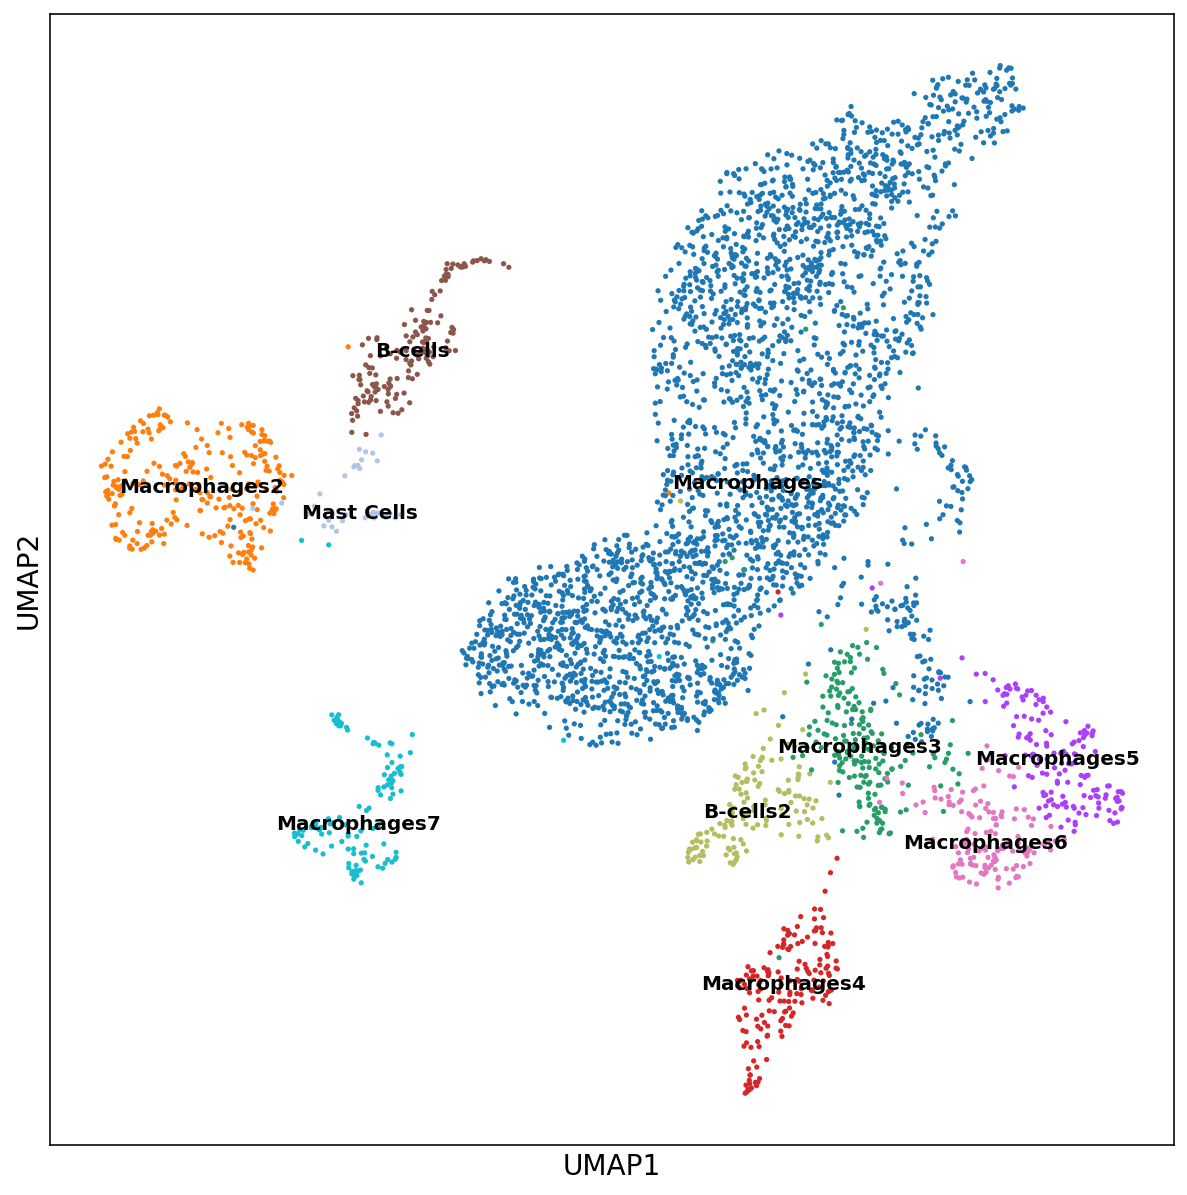

In [116]:
sc.pl.umap(adata,color='L1_result',legend_loc='on data', title='', save='.pdf')

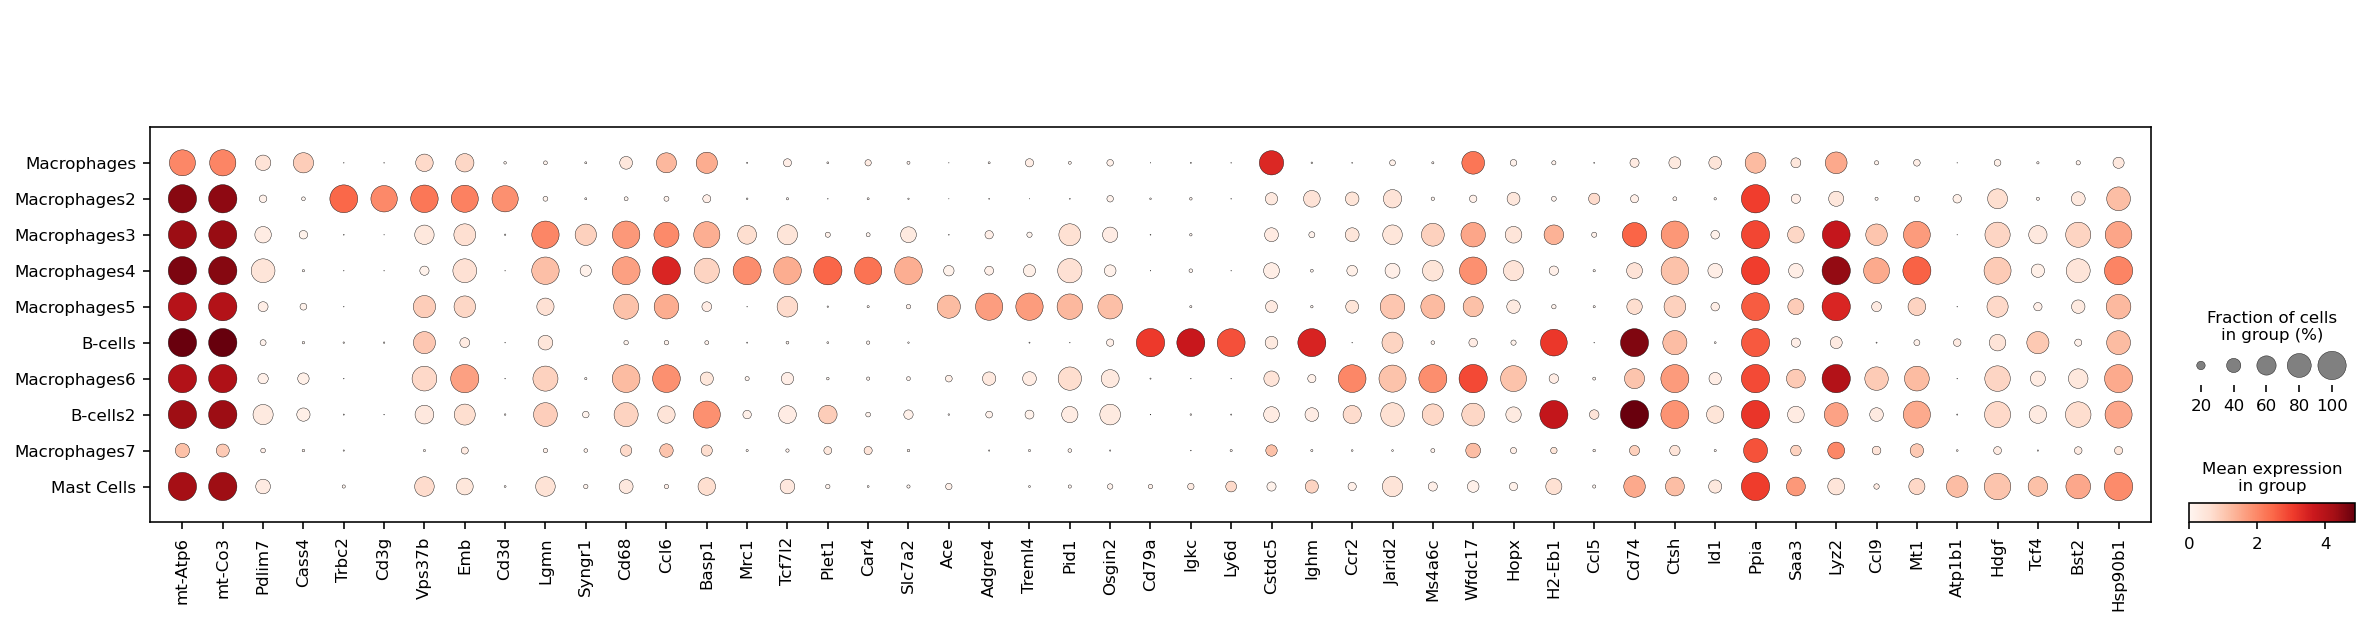

In [117]:
sc.pl.dotplot(adata, marker_genes, groupby='L1_result')

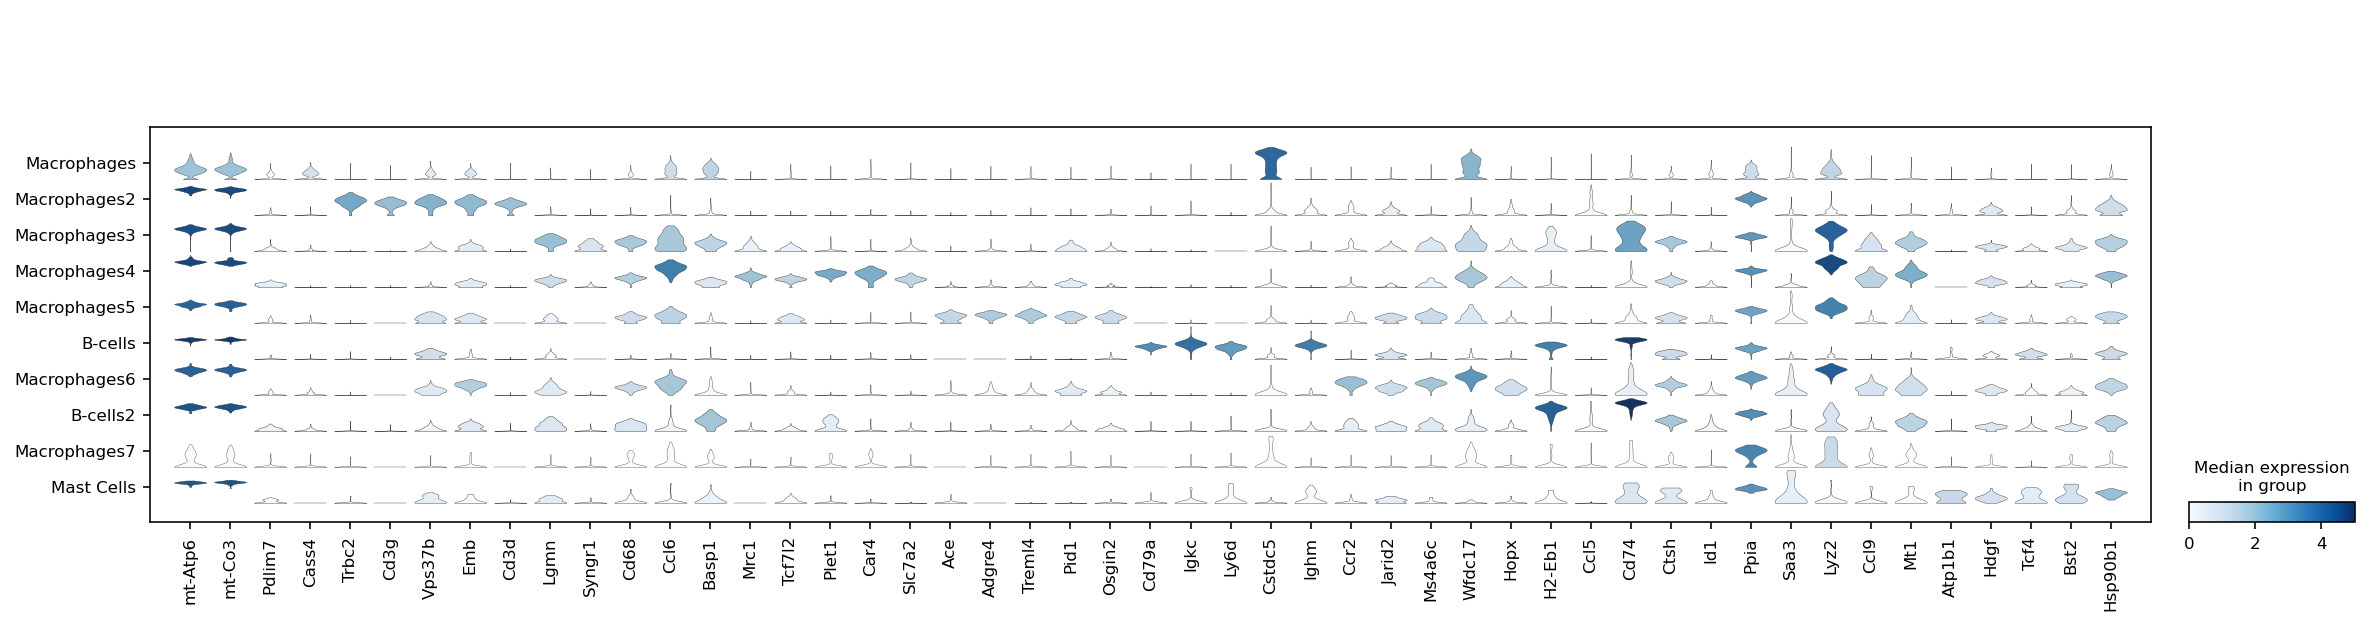

In [118]:
sc.pl.stacked_violin(adata, marker_genes, groupby='L1_result',rotation=90)